# Clean Medication data (inhaled and oral corticosteroids)

In [1]:
# load R packages
library(readxl)
packageVersion('readxl')
library(dplyr)
packageVersion('dplyr')
library(stringr)
packageVersion('stringr')
library(fastDummies)
packageVersion('fastDummies')
library(tidyr)
packageVersion('tidyr')
library(lubridate)
packageVersion('lubridate')
library(ggplot2)
packageVersion('ggplot2')

[1] ‘1.4.1’


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] ‘1.1.0’

[1] ‘1.4.1’

[1] ‘1.6.3’

[1] ‘1.2.1’


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




[1] ‘1.8.0’

[1] ‘3.4.4’

In [2]:
# set directory
project.dir = '...'
data.dir = '...'
regeps.dir = '...'
raw.rpdr.dir = file.path(regeps.dir, '...')
cleaned.rpdr.dir = file.path(regeps.dir, '...')
Qingwen.data.dir = file.path(regeps.dir, '...')

In [3]:
# check med file to see how many rows
med.lines <-readLines(file.path(raw.rpdr.dir, "Med.txt"))
length(med.lines)

[1] 1463942

In [4]:
# load med file
med.data <- read.delim(file.path(raw.rpdr.dir, "Med.txt"), sep = '|', quote="", fill=FALSE)
dim(med.data)
length(unique(med.data$EMPI))

[1] 1463941      16

[1] 928

In [5]:
# change format of med date
med.data$Medication_Date <- as.Date(med.data$Medication_Date, format = "%m/%d/%Y")
typeof(med.data$Medication_Date)

[1] "double"

In [6]:
table(med.data$Medication_Date_Detail) # check medication date detail


         Listed Removed 
1065309  350075   48557 

In [7]:
# The 'Removed' value denotes that a medication was removed from a patient's medication list -> exclude 'Removed'
med.listed <- med.data %>% filter(Medication_Date_Detail != 'Removed')
dim(med.listed) # from 1463941 to 1415384

[1] 1415384      16

In [8]:
table(med.listed$Medication_Date_Detail) # check after removing


         Listed 
1065309  350075 

In [9]:
# extract biobank ID
data.id <- read.csv(file.path(cleaned.rpdr.dir, 'Subject_Id.csv'))
dim(data.id)
# merge biobank.ID and med.data file
med.data.ID <- merge(med.listed,  data.id[,c('Subject_Id', 'EMPI')], by = 'EMPI')
dim(med.data.ID)

[1] 928   3

[1] 1415384      17

# ICS medication
- ICS Medication includes Beclomethasone dipropionate, Budesonide, Ciclesonide, Dexamethasone, Flunisolide, Fluticasone, Mometasone, Triamcinolone, Budesonide/formoterol, Fluticasone/salmeterol, Fluticasone/vilanterol, Formoterol/mometasone, and Betamethasone
- Filter based on variables under these above medication name in Biobank portal. The list is stored in ICS_medication_list.csv
- Check the list with Medication_Mapping. Wixela inhub is not in their ICS list -> confirmed Wixela inhub is ICS
- Remove any rows with ‘Removed’ in Medication_Date_Detail column because The ‘Removed’ denotes that a medication was removed from a patient’s medication list on the date indicated
- Remove ROUTE based on Lourdes's suggestion:
    + Remove ROUTE=Epid, ROUTE=IAtC, ROUTE=IM. ROUTE = See Amd Inst because they are injection
    + Remove ROUTE= Instranasal and ROUTE = Nasl because it is spray
    + Remove PO (by mouth) and they are budesonide
- Check ROUTE=NA. There are two medications: Veramyst is spray and Fluticasone propionate is ICS. Remove Veramyst
- NEB and NEBU are still ICS. ORAL are inhaled if they are for asthma treatment
- Lourdes suggested removing medications in data cohort because they are not ICS for asthma treatment: 
    + Beclomethasone 0.042% 25 m
    + Betamet acet/betamet na ph 12mg vial 2ml vial
    + Betamet acet/betamet na ph 6 mg/ml vial 5ml vial
    + Betamethasone soluspan - LMR 78
    + Budesonide 0.6 mg Intranasal Solution Cmpd
    + Budesonide Oral Suspension 0.6 mg/ml Cmpd BWH
    + Dexamethasone sod phospha
    + Dexamethasone sod phosphate 4 mg/ml vial 1ml vial
    + Fluticasone propionate 50 mcg spray 16gm aer w/adap
    + Fluticasone propionate 50 mcg spray susp 16gm aer w/adap

## ICS: Filter and clean medication

**ICS medication include: Beclomethasone dipropionate, Budesonide, Ciclesonide, Dexamethasone, Flunisolide, Fluticasone, Mometasone, Triamcinolone, Budesonide/formoterol, Fluticasone/salmeterol, Fluticasone/vilanterol, Formoterol/mometasone, and Betamethasone**

In [10]:
# load list of ICS medication
ics.biobank <- read.csv(file.path(data.dir, 'ICS_medication_list.csv'))
dim(ics.biobank)
length(unique(ics.biobank$ICS_medication))   # 225

[1] 238   7

[1] 225

In [11]:
ics.biobank.no.dup <- ics.biobank[!duplicated(ics.biobank), ] # some duplication
dim(ics.biobank.no.dup)
length(unique(ics.biobank.no.dup$ICS_medication))

[1] 225   7

[1] 225

In [12]:
# filter medication
ics.medication <- filter(med.data.ID, Medication %in% ics.biobank.no.dup$ICS_medication)
dim(ics.medication)

[1] 31634    17

In [13]:
# check with medication mapping
yulu.medication <- read_excel(file.path(Qingwen.data.dir,'Medication_Mapping.xlsx'))
yulu.medication <- data.frame(yulu.medication)

# select only ICS
yulu.ics <- yulu.medication %>% filter(ICS_or_ICS_LABA == 'yes')
head(yulu.ics)

,Medication_Name,Medication_Biobank_Folder,Medication_GWAS_Group,Medication_Pegasus_Group,ICS_or_ICS_LABA,Search_Term,Ignore.case,Perl
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>
1,Beclomethasone dipropionate,"Anti-inflammatories, inhalation",Inhaled Corticosteroids,Inhaled Steroids,yes,Beclomethasone([Dd]ipr)*((?![Nn]asal|80.*Aerosol).)*$|Beclovent|Beconase inhaler|Qvar|Vancenase inhaler|Vanceril,FALSE,TRUE
2,Betamethasone,Glucocorticoids,NA,Inhaled Steroids,yes,^Betamet( acet/|hasone (0.12|0.6|1mg|Acetate|Sodium|soluspan)|Celestone),FALSE,FALSE
3,Budesonide,"Anti-inflammatories, inhalation",Inhaled Corticosteroids,Inhaled Steroids,yes,^Budesonide(/formoterol fumarate 80| (-|0.25|0.5.*[Nn]eb|0.6|1|90|Inhl|inh |inhalation|nebulizer|[Oo]ral ))|^Pulmicort,FALSE,FALSE
4,Budesonide/formoterol,"Antiasthma, other",Inhaled Corticosteroids and Long Acting Beta Agonists,Inhaled Steroids,yes,[Bb]udesonide.*[Ff]ormoterol((?!6.9).)*$|Symbicort,FALSE,TRUE
5,Ciclesonide,"Anti-inflammatories, inhalation",Inhaled Corticosteroids,Inhaled Steroids,yes,Ciclesonide|Alvesco 160,FALSE,FALSE
6,Dexamethasone,"Anti-inflammatories, inhalation",Inhaled Corticosteroids,Inhaled Steroids,yes,^Dexamethasone sod phospha($|te 4 mg),FALSE,FALSE


In [14]:
# check ics match
search_terms <- unique(yulu.ics[,c('Medication_Name','Search_Term','Ignore.case','Perl')])
medications <- ics.medication$Medication

ics_map <- matrix(nrow=length(medications), ncol=2)
ics_map[,1] <- medications

for (n in c(1:length(medications))){
    for (i in c(1:nrow(search_terms))){
        if (grepl(search_terms[i,2], medications[n],ignore.case = search_terms[i,3],perl = search_terms[i,4])){
            print(paste(i,n))
            ics_map[n,2] <- search_terms[i,1]
        }
    }
}

[1] "9 1"
[1] "9 2"
[1] "9 3"
[1] "8 4"
[1] "9 5"
[1] "9 6"
[1] "9 7"
[1] "9 8"
[1] "9 9"
[1] "9 10"
[1] "9 11"
[1] "9 12"
[1] "9 13"
[1] "9 14"
[1] "9 15"
[1] "9 16"
[1] "9 17"
[1] "9 18"
[1] "9 19"
[1] "9 20"
[1] "9 21"
[1] "3 22"
[1] "9 23"
[1] "9 24"
[1] "9 25"
[1] "9 26"
[1] "8 27"
[1] "9 28"
[1] "3 29"
[1] "9 30"
[1] "9 31"
[1] "9 32"
[1] "10 33"
[1] "9 34"
[1] "9 35"
[1] "9 36"
[1] "9 37"
[1] "9 38"
[1] "9 39"
[1] "9 40"
[1] "9 41"
[1] "9 42"
[1] "9 43"
[1] "9 44"
[1] "9 45"
[1] "9 46"
[1] "9 47"
[1] "9 48"
[1] "3 49"
[1] "9 50"
[1] "3 51"
[1] "9 52"
[1] "9 53"
[1] "9 54"
[1] "9 55"
[1] "9 56"
[1] "9 57"
[1] "9 58"
[1] "9 59"
[1] "9 60"
[1] "8 61"
[1] "9 62"
[1] "9 63"
[1] "9 64"
[1] "9 65"
[1] "9 66"
[1] "9 67"
[1] "9 68"
[1] "9 69"
[1] "8 70"
[1] "9 71"
[1] "9 72"
[1] "9 73"
[1] "9 74"
[1] "9 75"
[1] "9 76"
[1] "10 77"
[1] "9 78"
[1] "9 79"
[1] "9 80"
[1] "9 81"
[1] "9 82"
[1] "9 83"
[1] "1 84"
[1] "1 85"
[1] "9 86"
[1] "9 87"
[1] "9 88"
[1] "1 89"
[1] "9 90"
[1] "9 91"
[1] "9

In [15]:
# medication not match --> Wixela inhub
ics_map <- data.frame(ics_map)
colnames(ics_map) <- c('Medication', 'Match_with_Yulu_file')
unique((ics_map[is.na(ics_map$Match_with_Yulu_file),])$Medication) 

[1] "Wixela inhub 100 mcg-50 mcg/dose powder for inhalation"
[2] "Wixela inhub 500 mcg-50 mcg/dose powder for inhalation"
[3] "Wixela inhub 250 mcg-50 mcg/dose powder for inhalation"

In [16]:
# remove medication based on clinician's suggestion
# create a list
not.ics <- c('Beclomethasone 0.042% 25 m',
                'Betamet acet/betamet na ph 12mg vial 2ml vial',
                'Betamet acet/betamet na ph 6 mg/ml vial 5ml vial',
                'Betamethasone soluspan - LMR 78',
                'Budesonide 0.6 mg Intranasal Solution Cmpd',
                'Budesonide Oral Suspension 0.6 mg/ml Cmpd BWH',
                'Dexamethasone sod phospha',
                'Dexamethasone sod phosphate 4 mg/ml vial 1ml vial',
                'Fluticasone propionate 50 mcg spray 16gm aer w/adap',
                'Fluticasone propionate 50 mcg spray susp 16gm aer w/adap',
                'Vancenase inhaler-oncall')

In [17]:
# remove not ICS
ics.medication <- filter(ics.medication,!(Medication %in% not.ics))
dim(ics.medication)

[1] 31249    17

**Note**: encounter number in med file is not same with encounter number in diag file. Same date, same patients, same med but different encounter number --> exclude encounter number

In [18]:
# selected columns
ics.med.selected.cols <- ics.medication %>% select(Subject_Id,Medication_Date, Medication, Additional_Info) %>%
                                            arrange(Subject_Id, Medication_Date)
dim(ics.med.selected.cols)
length(unique(ics.med.selected.cols$Subject_Id)) # 917

[1] 31249     4

[1] 917

In [19]:
# extract ROUTE infomation from Additional info
ics.med.selected.cols$Route <- str_extract(ics.med.selected.cols$Additional_Info, "ROUTE=[^;]+")
# check route
table(ics.med.selected.cols$Route)


         ROUTE=AER         ROUTE=Epid         ROUTE=IAtc           ROUTE=IM 
                 3                  2                 12                  4 
         ROUTE=INH         ROUTE=Inhl           ROUTE=NA         ROUTE=Nasl 
              3880               6483                 55                  4 
         ROUTE=NEB         ROUTE=Nebu         ROUTE=Oral           ROUTE=PO 
                80                335                 34                 24 
ROUTE=See Adm Inst 
                17 

In [20]:
unique((ics.med.selected.cols %>% filter(Route == 'ROUTE=Epid'))$Medication)
ics.med.selected.cols %>% filter(Route == 'ROUTE=Epid')
# remove because of injection
dim(ics.med.selected.cols %>% filter(Medication == 'Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection')) 

[1] "Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection"

Subject_Id,Medication_Date,Medication,Additional_Info,Route
<int>,<date>,<chr>,<chr>,<chr>
10011705,2019-10-03,Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection,DOSE=18 MG; FREQ=Once; ROUTE=Epid,ROUTE=Epid
10095472,2018-06-27,Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection,DOSE=12 MG; FREQ=Once; ROUTE=Epid,ROUTE=Epid


[1] 89  5

In [21]:
# removed because of injection
unique((ics.med.selected.cols %>% filter(Route == 'ROUTE=IAtc'))$Medication)

[1] "Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection"

In [22]:
unique((ics.med.selected.cols %>% filter(Route == 'ROUTE=IM'))$Medication) # remove because they are injected

[1] "Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection"

In [23]:
# not ICS because it is spray
unique((ics.med.selected.cols %>% filter(Route == 'ROUTE=Nasl'))$Medication)

[1] "Fluticasone propionate 93 mcg/actuation breath activated aerosol"
[2] "Flovent Hfa 220 mcg/Actuation Aerosol Inhaler"

In [24]:
unique((ics.med.selected.cols %>% filter(Route == 'ROUTE=PO'))$Medication) # not inhale 

[1] "Budesonide - LMR 3748"

In [25]:
unique((ics.med.selected.cols %>% filter(Route == 'ROUTE=Oral'))$Medication)

[1] "Fluticasone 110 mcg/Actuation Hfa Aerosol Inhaler"
[2] "Fluticasone 220 mcg/Actuation Hfa Aerosol Inhaler"
[3] "Budesonide 1 mg/2 ml Suspension For Nebulization" 
[4] "Flovent Hfa 110 mcg/Actuation Aerosol Inhaler"    
[5] "Flovent Hfa 220 mcg/Actuation Aerosol Inhaler"    
[6] "Flovent Hfa 44 mcg/Actuation Aerosol Inhaler"     
[7] "Fluticasone 44 mcg/Actuation Hfa Aerosol Inhaler"

In [26]:
unique((ics.med.selected.cols %>% filter(Route == 'ROUTE=See Adm Inst'))$Medication) # injection

[1] "Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection"
[2] "Budesonide 0.5 mg/2 ml Suspension For Nebulization"

In [27]:
dim(ics.med.selected.cols %>% filter(Medication == 'Fluticasone propionate/salmeterol 250/50 (advair diskus 250/50)- lmr 3623')) 
# keep

[1] 3223    5

In [28]:
dim(ics.med.selected.cols %>% filter(Medication == 'Veramyst (fluticasone furoate) - LMR 6049')) # need to be removed

[1] 319   5

In [29]:
table(ics.med.selected.cols$Route)
sum(is.na(ics.med.selected.cols$Route)) # 20316 missing route
length(unique(ics.med.selected.cols$Medication))
dim(ics.med.selected.cols)


         ROUTE=AER         ROUTE=Epid         ROUTE=IAtc           ROUTE=IM 
                 3                  2                 12                  4 
         ROUTE=INH         ROUTE=Inhl           ROUTE=NA         ROUTE=Nasl 
              3880               6483                 55                  4 
         ROUTE=NEB         ROUTE=Nebu         ROUTE=Oral           ROUTE=PO 
                80                335                 34                 24 
ROUTE=See Adm Inst 
                17 

[1] 20316

[1] 185

[1] 31249     5

In [30]:
# remove epid, iatc, see amd inst, nasl, PO, NA
ics.removed.route <- ics.med.selected.cols %>%  filter(!Route %in% c('ROUTE=Epid', 'ROUTE=IAtc', 'ROUTE=IM',
                                                            'ROUTE=Nasl', 'ROUTE=PO', 
                                                            'ROUTE=See Adm Inst'))
dim(ics.removed.route)
length(unique(ics.removed.route$Medication)) # 184 med
table(ics.removed.route$Route)

[1] 31186     5

[1] 184


 ROUTE=AER  ROUTE=INH ROUTE=Inhl   ROUTE=NA  ROUTE=NEB ROUTE=Nebu ROUTE=Oral 
         3       3880       6483         55         80        335         34 

In [31]:
# check any medication have injection in name
unique((ics.removed.route %>% filter(str_detect(Medication, 'inject|Inject')))$Medication) # 55 -> remove
# remove Betamethasone Injection
ics.removed.route <- ics.removed.route %>% filter(Medication != 'Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection')
dim(ics.removed.route)

[1] "Betamethasone Acetate And Sodium Phos 6 mg/ml Suspension For Injection"

[1] 31131     5

In [32]:
# check any medication have nasal in name
ics.removed.route %>% filter(str_detect(Medication, 'nasal|Nasal')) # none

Subject_Id,Medication_Date,Medication,Additional_Info,Route
<int>,<date>,<chr>,<chr>,<chr>


In [33]:
# remove Veramyst
ics.removed.route <- ics.removed.route %>% filter(Medication != 'Veramyst (fluticasone furoate) - LMR 6049')
dim(ics.removed.route)

[1] 30812     5

In [34]:
length(unique(ics.removed.route$Medication)) # 182

[1] 182

In [35]:
# Select only interested columns
ics.selected.cols <- ics.removed.route %>% select('Subject_Id', 'Medication_Date', 
                                                  'Medication', 'Additional_Info') %>%
                                            arrange('Subject_Id', 'Medication_Date', 'Medication')

dim(ics.selected.cols)

[1] 30812     4

In [36]:
# uniform dose unit due to lowcase and upcase or abbr
ics.selected.cols.1 <- ics.selected.cols %>% mutate(Additional_Info = gsub('PUFFS', 'PUFF', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub('INHALATION', 'PUFF', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub('SPRAY', 'PUFF', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub('mcg', 'MCG', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub('MCG/tx fluti', 'MCG', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub('ml', 'ML', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub('mL', 'ML', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub(' of fluti', '', Additional_Info),
                        Additional_Info = gsub('Inhl', 'INH', Additional_Info, ignore.case = TRUE),
                        Additional_Info = gsub('Nebu', 'NEB', Additional_Info, ignore.case = TRUE))

In [37]:
# split Dose info in Additional info
ics.selected.cols.1$Dose_from_info <- str_extract(ics.selected.cols.1$Additional_Info, "DOSE=[^;]+")
ics.selected.cols.1$Dose_from_info <- str_replace(ics.selected.cols.1$Dose_from_info, "DOSE=", "")
unique(ics.selected.cols.1$Dose_from_info)

[1] NA            "1 PUFF"      "100 MCG"     "2 PUFF"      "0.5 MG"     
 [6] "500 MCG"     "0.11 MG"     "250 MCG"     "1 MG"        "230 MCG"    
[11] "0.22 MG"     "0.88 MG"     "0.25 MG"     "460 MCG"     "0.44 MG"    
[16] "440 MCG"     "200 MCG"     "0.36 MG"     "2 @"         "3 PUFF"     
[21] "0.044 MG"    "0.088 MG"    "0.18 MG"     "0.2 MG"      "4 PUFF"     
[26] "2 MG"        "2 ML"        "160 MCG"     "1 Blister"   "0.54 MG"    
[31] "115 MCG"     "6 PUFF"      "0.72 MG"     "550 MCG"     "0.08 MG"    
[36] "200 INHALER" "110 MCG"     "1 VIAL"      "0.04 MG"     "180 MCG"    
[41] "8 PUFF"      "550 @"       "0.4 MG"      "90 MCG"      "180 PUFF"   
[46] "1 INHALER"   "5500 MCG"    "80 MCG"      "110 PUFF"    "44 MCG"     
[51] "1 EA"        "4 MG"

In [38]:
# load ics med. This file has dose info in name
ics.med.dose <- read_excel(file.path(data.dir, 'ICS_Med.xlsx')) # Lourdes QCed
dim(ics.med.dose)

[1] 182  13

In [39]:
# merge to have dose from name
dim(ics.selected.cols.1)
ics.selected.cols.2 <- ics.selected.cols.1 %>% left_join(ics.med.dose[,c('Medication', 'Med_common_name','MCG_from_Name','Medication_group')], 
                                                     by = 'Medication')
dim(ics.selected.cols.2)

[1] 30812     5

[1] 30812     8

In [40]:
# split Dose info in Additional info
ics.selected.cols.2$Dose_from_info <- str_extract(ics.selected.cols.2$Additional_Info, "DOSE=[^;]+")
ics.selected.cols.2$Dose_from_info <- str_replace(ics.selected.cols.2$Dose_from_info, "DOSE=", "")
unique(ics.selected.cols.2$Dose_from_info)

[1] NA            "1 PUFF"      "100 MCG"     "2 PUFF"      "0.5 MG"     
 [6] "500 MCG"     "0.11 MG"     "250 MCG"     "1 MG"        "230 MCG"    
[11] "0.22 MG"     "0.88 MG"     "0.25 MG"     "460 MCG"     "0.44 MG"    
[16] "440 MCG"     "200 MCG"     "0.36 MG"     "2 @"         "3 PUFF"     
[21] "0.044 MG"    "0.088 MG"    "0.18 MG"     "0.2 MG"      "4 PUFF"     
[26] "2 MG"        "2 ML"        "160 MCG"     "1 Blister"   "0.54 MG"    
[31] "115 MCG"     "6 PUFF"      "0.72 MG"     "550 MCG"     "0.08 MG"    
[36] "200 INHALER" "110 MCG"     "1 VIAL"      "0.04 MG"     "180 MCG"    
[41] "8 PUFF"      "550 @"       "0.4 MG"      "90 MCG"      "180 PUFF"   
[46] "1 INHALER"   "5500 MCG"    "80 MCG"      "110 PUFF"    "44 MCG"     
[51] "1 EA"        "4 MG"

In [41]:
# each blister contains 250 mcg of fluticasone
# replace 1 Blister with 250 mcg
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '1 Blister'] <- '250 MCG'

In [42]:
# one inhaler is 200 mcg Fluticasone
# Breo Ellipta Inhl. The maximum of Breo ellipta is 200/25 as 1 inhalation once daily 
# -> infor: 200 inhaler should be 200 mcg
# replace with 200 MCG
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '200 INHALER'] <- 'NA'
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '1 INHALER'] <- '200 MCG'

In [43]:
# 1 vial is 2 ml and 0.25 mg
# replace 1 VIAL with 0.25 mg
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '1 VIAL'] <- '0.25 MG'

In [44]:
# Recommended starting Dose_from_info: 100 mcg/day. Replace 1 EA with 100 MCG
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '1 EA'] <- '100 MCG'

In [45]:
# 1 inhalation (1 PUFF) and 1 PUFF has 100 MCG or 500 MCG of Fluti. 2@ can be 2 PUFFS.
# For preventing an asthma attack, adults can have 2 Puffs in the morning and another 2 puffs in the evening
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '2 @'] <- '2 PUFF'
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '550 @'] <- 'NA'

In [46]:
# Each single-Dose_from_info ampule contains 2 mL of sterile liquid suspension -> replace 2 ML to 0.5 MG (500 MCG)
ics.selected.cols.2$Dose_from_info[ics.selected.cols.2$Dose_from_info == '2 ML'] <- '500 MCG'

In [47]:
# check PUFF
# for Advair Diskus 250 mcg-50 mcg/Dose_from_info Powder For Inhalation. The maximum is 1000 MCG per day
# for Advair Hfa 115 mcg-21 mcg/Actuation Aerosol Inhaler. 2 puffs in the morning and 2 puffs in the afternoon. 
# Medication name mcg per puff

In [48]:
# check MCG
# for Advair Diskus 250 mcg-50 mcg/Dose_from_info Powder For Inhalation. The maximum is 1000 MCG per day
# for Advair Hfa 115 mcg-21 mcg/Actuation Aerosol Inhaler. 2 puffs in the morning and 2 puffs in the afternoon. 
# Medication name mcg per puff

In [49]:
# replace freq
ics.selected.cols.2$Freq <- str_extract(ics.selected.cols.2$Additional_Info, "FREQ=[^;]+")
unique(ics.selected.cols.2$Freq)

[1] NA                            "FREQ=BID"                   
 [3] "FREQ=Daily"                  "FREQ=BID RESP"              
 [5] "FREQ=BID PRN"                "FREQ=Q12H"                  
 [7] "FREQ=Once"                   "FREQ=PRN"                   
 [9] "FREQ=UD"                     "FREQ=QD"                    
[11] "FREQ=4x Daily"               "FREQ=Daily PRN"             
[13] "FREQ=Nightly"                "FREQ=QHS"                   
[15] "FREQ=QPM"                    "FREQ=QAM"                   
[17] "FREQ=See Admin Instructions" "FREQ=Q12H PRN"              
[19] "FREQ=QID"                    "FREQ=TID"                   
[21] "FREQ=QNOON"                  "FREQ=BID Diuretic"          
[23] "FREQ=QOD"                    "FREQ=4x Daily PRN"          
[25] "FREQ=Nightly PRN"            "FREQ=Daily RESP"            
[27] "FREQ=Before Breakfast"       "FREQ=Q12H SCH"              
[29] "FREQ=Q24H"                   "FREQ=Q6H PRN"

In [50]:
# Replace FREQ=QOD with 0.5 (every other day)
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=QOD'] <- 0.5

In [51]:
# Replace Daily|Nightly|Once|QAM|QD|QNOON|QPM|Q24 with 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Daily'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Once'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=QD'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Daily PRN'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Nightly'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Nightly PRN'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Q24H'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=QPM'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=QAM'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=QNOON'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Daily RESP'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Before Breakfast'] <- 1
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=QHS'] <- 1 # each night before breakfast

In [52]:
# Replace FREQ=BID and Q12H with 2
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=BID'] <- 2
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=BID RESP'] <- 2
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=BID PRN'] <- 2
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=BID Diuretic'] <- 2
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Q12H'] <- 2
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Q12H PRN'] <- 2
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Q12H SCH'] <- 2

In [53]:
# Replace FREQ=TID with 3
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=TID'] <- 3

In [54]:
# Replace 4x Daily|QID|Q6H with 4
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=4x Daily'] <- 4
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=4x Daily PRN'] <- 4
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=Q6H PRN'] <- 4
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=QID'] <- 4

In [55]:
# UD: as directed and PRN: rescribed as needed
# replace PRN, UD, See Admin Instructions with NA
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=PRN'] <- NA
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=UD'] <- NA
ics.selected.cols.2$Freq[ics.selected.cols.2$Freq == 'FREQ=See Admin Instructions'] <- NA

In [56]:
unique(ics.selected.cols.2$Freq) # check after replacing

[1] NA    "2"   "1"   "4"   "3"   "0.5"

In [57]:
ics.selected.cols.2[["Freq"]][is.na(ics.selected.cols.2[["Freq"]])] <- 1 # replace NA Freq is 1
summary(as.numeric(ics.selected.cols.2$Freq))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.50    1.00    1.00    1.33    2.00    4.00 

In [58]:
# sel cols
ics.selected.cols.3 <- ics.selected.cols.2 %>% select(Subject_Id, Medication_Date, Med_common_name, Medication_group,
                                                      Dose_from_info, MCG_from_Name, Freq)
dim(ics.selected.cols.3)

[1] 30812     7

In [59]:
# Split Dose_from_info column into number and unit
ics.selected.cols.3[c('Dose_num_from_info', 'Dose_unit_from_info')] <- str_split_fixed(ics.selected.cols.3$Dose_from_info, ' ', 2)
ics.selected.cols.3["Dose_num_from_info"][ics.selected.cols.3["Dose_num_from_info"] == ''] <- 'NA'
ics.selected.cols.3["Dose_unit_from_info"][ics.selected.cols.3["Dose_unit_from_info"] == ''] <- 'NA'
dim(ics.selected.cols.3)

[1] 30812     9

In [60]:
unique(ics.selected.cols.3$Dose_unit_from_info)
unique(ics.selected.cols.3$Dose_num_from_info)
unique(ics.selected.cols.3$Dose_from_info)

[1] "NA"   "PUFF" "MCG"  "MG"

[1] "NA"    "1"     "100"   "2"     "0.5"   "500"   "0.11"  "250"   "230"  
[10] "0.22"  "0.88"  "0.25"  "460"   "0.44"  "440"   "200"   "0.36"  "3"    
[19] "0.044" "0.088" "0.18"  "0.2"   "4"     "160"   "0.54"  "115"   "6"    
[28] "0.72"  "550"   "0.08"  "110"   "0.04"  "180"   "8"     "0.4"   "90"   
[37] "5500"  "80"    "44"

[1] NA         "1 PUFF"   "100 MCG"  "2 PUFF"   "0.5 MG"   "500 MCG" 
 [7] "0.11 MG"  "250 MCG"  "1 MG"     "230 MCG"  "0.22 MG"  "0.88 MG" 
[13] "0.25 MG"  "460 MCG"  "0.44 MG"  "440 MCG"  "200 MCG"  "0.36 MG" 
[19] "3 PUFF"   "0.044 MG" "0.088 MG" "0.18 MG"  "0.2 MG"   "4 PUFF"  
[25] "2 MG"     "160 MCG"  "0.54 MG"  "115 MCG"  "6 PUFF"   "0.72 MG" 
[31] "550 MCG"  "0.08 MG"  "NA"       "110 MCG"  "0.04 MG"  "180 MCG" 
[37] "8 PUFF"   "0.4 MG"   "90 MCG"   "180 PUFF" "5500 MCG" "80 MCG"  
[43] "110 PUFF" "44 MCG"   "4 MG"

In [61]:
table(ics.selected.cols.3$Dose_num_from_info)
table(ics.selected.cols.3$MCG_from_Name)
table(ics.selected.cols.3$Dose_num_from_info)


 0.04 0.044  0.08 0.088  0.11  0.18   0.2  0.22  0.25  0.36   0.4  0.44   0.5 
    1    41     1    13    88    62     9   134    50    18     3    31   293 
 0.54  0.72  0.88     1   100   110   115   160   180     2   200   230   250 
    1     2     3  4994   372     2     1     8     3  3546     5    40   325 
    3     4    44   440   460   500   550  5500     6     8    80    90    NA 
   14    46     1     2    13   460     2     1    13     2     2     6 20204 


 100 1000  110  113  115  160  180  200  220  230  232  250   40   44   45   50 
2700   53 3024    7  204 2289 1171  175 2565  294    4 5498  403  911   49   12 
 500   55   80   90   NA 
6378    4 1319  252 3500 


 0.04 0.044  0.08 0.088  0.11  0.18   0.2  0.22  0.25  0.36   0.4  0.44   0.5 
    1    41     1    13    88    62     9   134    50    18     3    31   293 
 0.54  0.72  0.88     1   100   110   115   160   180     2   200   230   250 
    1     2     3  4994   372     2     1     8     3  3546     5    40   325 
    3     4    44   440   460   500   550  5500     6     8    80    90    NA 
   14    46     1     2    13   460     2     1    13     2     2     6 20204 

In [62]:
# change column type
ics.selected.cols.3$Dose_num_from_info <- as.numeric(ics.selected.cols.3$Dose_num_from_info)
ics.selected.cols.3$MCG_from_Name <- as.numeric(ics.selected.cols.3$MCG_from_Name)
ics.selected.cols.3$Dose_num_from_info <- as.numeric(ics.selected.cols.3$Dose_num_from_info)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [63]:
sum(is.na(ics.selected.cols.3$Dose_num_from_info))
sum(is.na(ics.selected.cols.3$MCG_from_Name))

[1] 20204

[1] 3500

In [64]:
# convert MG to MCG and 1 PUFF is 1 dose with dose from name. if no dose info in addtional info, use dose from name
ics.selected.cols.3$MCG_dose_combined <- NA
ics.selected.cols.3$MCG_dose_combined <- ifelse(ics.selected.cols.3$Dose_unit_from_info == 'MCG',ics.selected.cols.3$Dose_num_from_info, 
                                          ifelse(ics.selected.cols.3$Dose_unit_from_info == 'MG',ics.selected.cols.3$Dose_num_from_info*1000, 
                                                  ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '1',ics.selected.cols.3$MCG_from_Name, 
                                                         ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '2',ics.selected.cols.3$MCG_from_Name*2, 
                                                                ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '3',ics.selected.cols.3$MCG_from_Name*3, 
                                                                       ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '4',ics.selected.cols.3$MCG_from_Name*4, 
                                                                              ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '6',ics.selected.cols.3$MCG_from_Name*6, 
                                                                                     ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '8',ics.selected.cols.3$MCG_from_Name*8, 
                                                                                            ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '110',ics.selected.cols.3$MCG_from_Name*110, 
                                                                                                   ifelse(ics.selected.cols.3$Dose_unit_from_info == 'PUFF' & 
                                                         ics.selected.cols.3$Dose_num_from_info == '180',ics.selected.cols.3$MCG_from_Name*180, 
                                                                                                          ifelse(is.na(ics.selected.cols.3$Dose_num_from_info), 
                                                                                                                 ics.selected.cols.3$MCG_from_Name,'NA')))))))))))

In [65]:
unique(ics.selected.cols.3$MCG_dose_combined)

[1] "500"   "250"   "100"   "110"   NA      "460"   "320"   "160"   "220"  
[10] "44"    "88"    "180"   "1000"  "230"   "80"    "40"    "200"   "360"  
[19] "90"    "880"   "440"   "300"   "330"   "55"    "232"   "113"   "400"  
[28] "50"    "115"   "660"   "132"   "2000"  "45"    "540"   "720"   "270"  
[37] "1080"  "550"   "1760"  "1320"  "32400" "5500"  "960"   "4000"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   40.0   110.0   250.0   268.7   440.0 32400.0    3166 

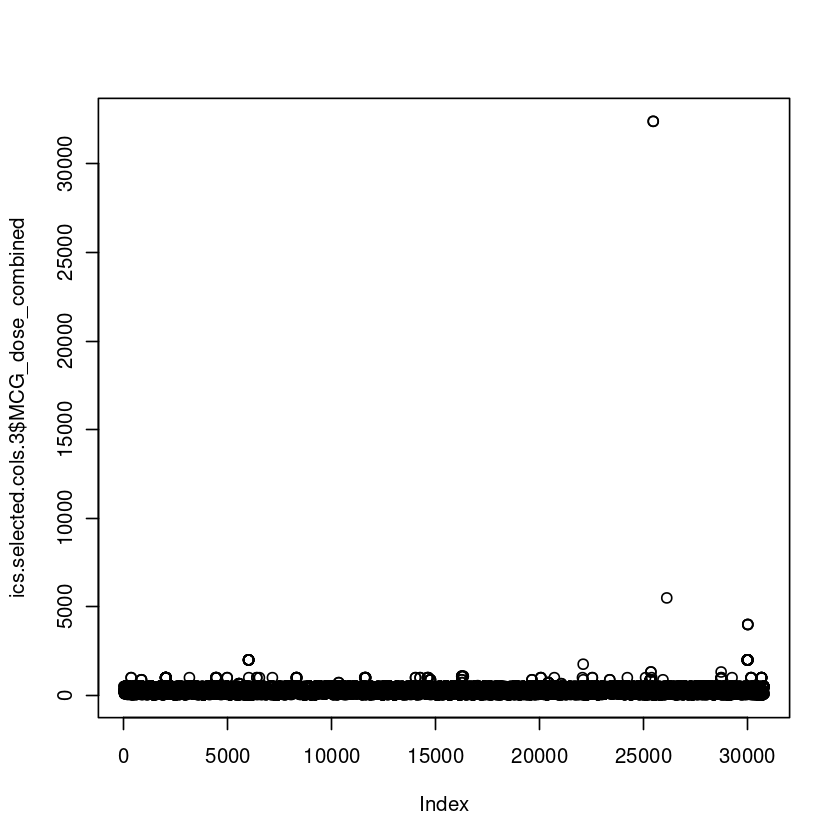

In [66]:
ics.selected.cols.3$MCG_dose_combined <- as.numeric(ics.selected.cols.3$MCG_dose_combined)
summary(ics.selected.cols.3$MCG_dose_combined)
plot(ics.selected.cols.3$MCG_dose_combined)

In [67]:
# replace with dose from name
ics.selected.cols.3['MCG_dose_combined'][ics.selected.cols.3['MCG_dose_combined'] == 32400] <- 180 
ics.selected.cols.3['MCG_dose_combined'][ics.selected.cols.3['MCG_dose_combined'] == 5500] <- 500 
ics.selected.cols.3['MCG_dose_combined'][ics.selected.cols.3['MCG_dose_combined'] == 4000] <- 500

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   40.0   110.0   250.0   265.8   440.0  2000.0    3166 

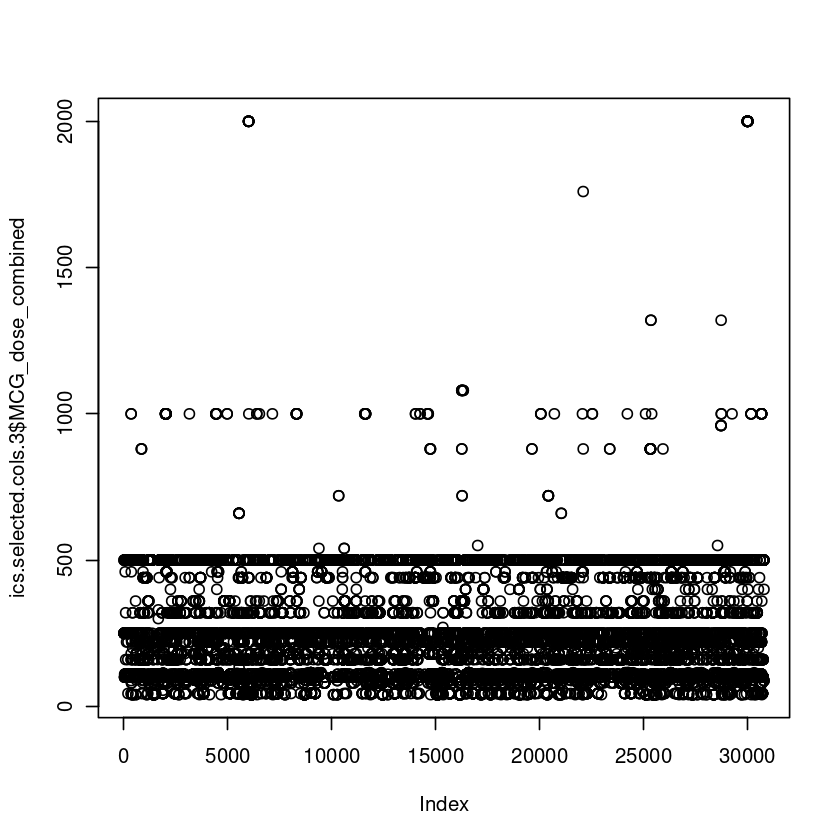

In [68]:
# check after replacing
summary(ics.selected.cols.3$MCG_dose_combined)
plot(ics.selected.cols.3$MCG_dose_combined)

In [69]:
ics.selected.cols.3$Freq <- as.numeric(ics.selected.cols.3$Freq)
summary(ics.selected.cols.3$Freq)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.50    1.00    1.00    1.33    2.00    4.00 

In [70]:
sum(is.na(ics.selected.cols.3$Freq))
sum(is.na(ics.selected.cols.3$MCG_dose_combined))

[1] 0

[1] 3166

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
     40     160     250     378     500    4000    3166 

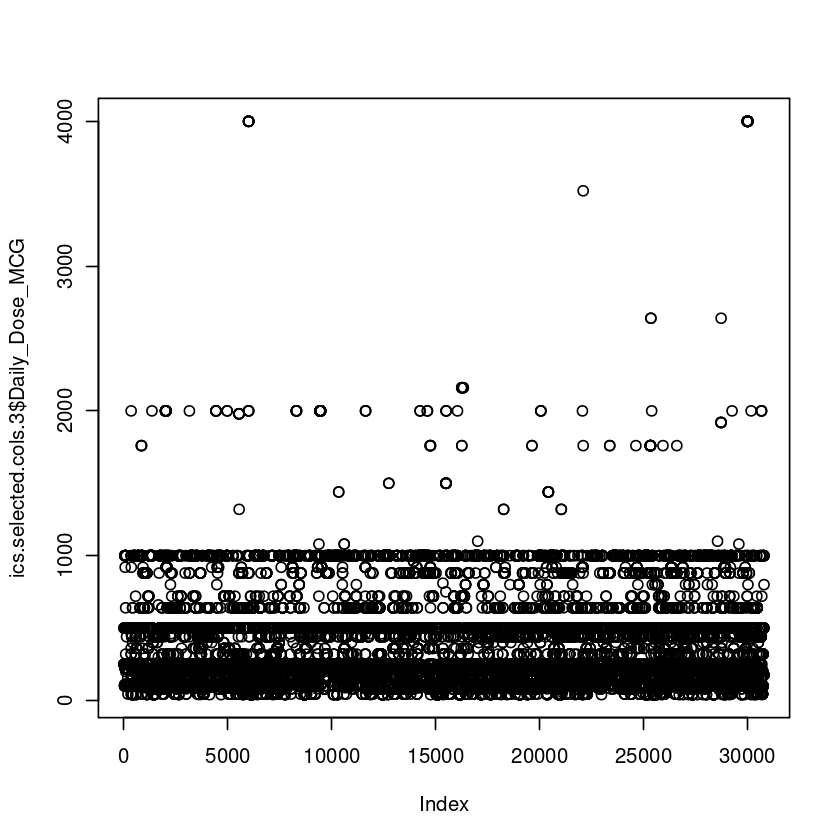

In [71]:
# calculate daily dose = freq x mcg_dose
ics.selected.cols.3$Daily_Dose_MCG <- ics.selected.cols.3$MCG_dose_combined * ics.selected.cols.3$Freq
summary(ics.selected.cols.3$Daily_Dose_MCG)
plot(ics.selected.cols.3$Daily_Dose_MCG)

In [72]:
length(unique(ics.selected.cols.3$Subject_Id))

[1] 914

In [73]:
dim(ics.selected.cols.3)
ics.selected.cols.4 <- ics.selected.cols.3 %>% select(Subject_Id,Medication_Date,Med_common_name,Medication_group,Daily_Dose_MCG)
dim(ics.selected.cols.4)

[1] 30812    11

[1] 30812     5

## ICS: Remove duplication

In [74]:
dim(ics.selected.cols.4[duplicated(ics.selected.cols.4),]) # dup rows

[1] 877   5

In [75]:
# remove dup rows
dim(ics.selected.cols.4)
ics.no.dup.rows <- ics.selected.cols.4[!duplicated(ics.selected.cols.4),]
dim(ics.no.dup.rows)

[1] 30812     5

[1] 29935     5

In [76]:
# check dup
dim(ics.no.dup.rows[duplicated(ics.no.dup.rows),])

[1] 0 5

In [77]:
summary(ics.no.dup.rows$Daily_Dose_MCG)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   40.0   160.0   250.0   376.1   500.0  4000.0    3012 

In [78]:
# remove missing values
dim(ics.no.dup.rows)
ics.dose.no.missing <- ics.no.dup.rows %>% filter(!is.na(Daily_Dose_MCG))
dim(ics.dose.no.missing)
summary(ics.dose.no.missing$Daily_Dose_MCG)

[1] 29935     5

[1] 26923     5

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   40.0   160.0   250.0   376.1   500.0  4000.0 

In [79]:
# find max dose value by Med date because there are some patients have several dosage in same medication in one day 
# --> select max dose in each day
ics.med.dose.max <- ics.dose.no.missing %>% group_by(Subject_Id, Medication_Date, Med_common_name) %>% 
                                 summarise_at(vars('Daily_Dose_MCG'), c(max))
colnames(ics.med.dose.max) <- c('Subject_Id', 'Medication_Date', 'Med_common_name', 'Max_Daily_Dose_MCG')

In [80]:
# check dup 
#ics.med.dose.max %>%
# group_by(Subject_Id, Medication_Date) %>%
#  filter(n()>1) %>%
#  ungroup()

In [81]:
length(unique(ics.med.dose.max$Subject_Id))

[1] 895

## ICS: Number of prescription within 5Y (before and after plasma collect date)

In [82]:
# use ics.no.dup.rows for number of prescription because ics.med.dose.max removes missing values
ics.med.group <- ics.no.dup.rows %>% select(Subject_Id, Medication_Date, Medication_group)
dim(ics.med.group[duplicated(ics.med.group),]) # 3544 dup rows

[1] 3544    3

In [83]:
dim(ics.med.group)
ics.dose.no.dup <- ics.med.group[!duplicated(ics.med.group),]
dim(ics.dose.no.dup)

[1] 29935     3

[1] 26391     3

In [84]:
ics.dose.no.dup$Prescription <- 1 # assign 1 for a prescription

In [85]:
# Total number of prescription
# Group by Subject_Id and sum of medication using dplyr
ics.prescr.counts.per.ind <- ics.dose.no.dup %>% group_by(Subject_Id) %>% 
  summarise(ICS_total_number_of_prescriptions = sum(Prescription),
            .groups = 'drop')
dim(ics.prescr.counts.per.ind)

[1] 914   2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    8.00   20.00   28.87   39.00  319.00 

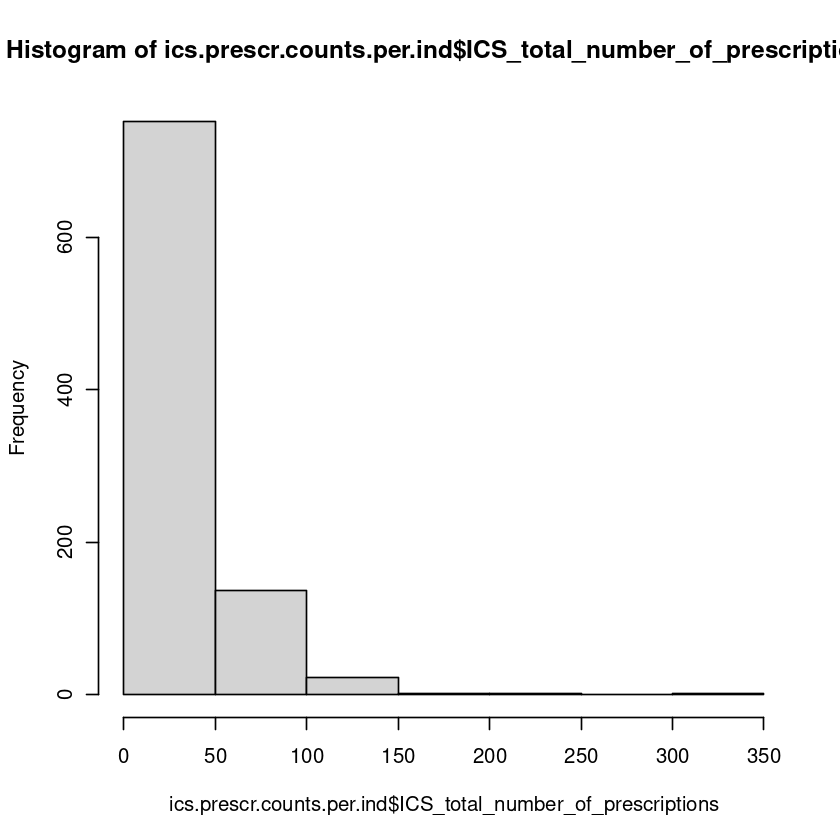

In [86]:
# summary statistic
summary(ics.prescr.counts.per.ind$ICS_total_number_of_prescriptions)
hist(ics.prescr.counts.per.ind$ICS_total_number_of_prescriptions)

In [87]:
# Calculate date difference based on plasma collection date
ics.med.group.w.date <- merge(ics.dose.no.dup, data.id[,c('Subject_Id', 'Plasma_collect_date')], 
                              by = 'Subject_Id')
dim(ics.med.group.w.date)

[1] 26391     5

In [88]:
# convert the date column to the Y-M-D format
ics.med.group.w.date$Medication_Date <- as.Date(ics.med.group.w.date$Medication_Date, format = "%m/%d/%Y")
typeof(ics.med.group.w.date$Medication_Date)
head(ics.med.group.w.date$Medication_Date)

# plasma collect date
ics.med.group.w.date$Plasma_collect_date <- as.Date(ics.med.group.w.date$Plasma_collect_date, format = "%Y -%m -%d")
typeof(ics.med.group.w.date$Plasma_collect_date)
head(ics.med.group.w.date$Plasma_collect_date)

[1] "double"

[1] "2004-02-03" "2004-05-19" "2008-10-24" "2010-01-06" "2010-03-17"
[6] "2010-03-26"

[1] "double"

[1] "2010-11-03" "2010-11-03" "2010-11-03" "2010-11-03" "2010-11-03"
[6] "2010-11-03"

In [89]:
# substract collect date and diag date
ics.med.group.w.date["Days_Difference"] <- difftime(ics.med.group.w.date$Plasma_collect_date, 
                                                    ics.med.group.w.date$Medication_Date, units = "days")
ics.med.group.w.date$Days_Difference <- as.numeric(ics.med.group.w.date$Days_Difference)
head(ics.med.group.w.date$Days_Difference,10)
# absolute values
ics.med.group.w.date["Days_Difference_Abs"] <- as.numeric(abs(ics.med.group.w.date$Days_Difference))
head(ics.med.group.w.date$Days_Difference_Abs,10)

[1] 2465 2359  740  301  231  222  105   21 -427 -516

[1] 2465 2359  740  301  231  222  105   21  427  516

In [90]:
typeof(ics.med.group.w.date$Days_Difference)
typeof(ics.med.group.w.date$Days_Difference_Abs)

[1] "double"

[1] "double"

In [91]:
# create a dataset of no of prescriptions within 5 years based on sample collection date
ics.5y <- ics.med.group.w.date %>% filter(Days_Difference_Abs <= 1826)
dim(ics.5y)

# check how many individuals have ICS prescriptions within the last 5 years based on sample collection date
length(unique(ics.5y$Subject_Id)) # only 891 individuals

[1] 19121     7

[1] 891

In [92]:
summary(as.numeric(ics.5y$Days_Difference))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1826.0  -517.0   117.0   122.9   839.0  1826.0 

In [93]:
# Group by Subject_Id and sum of medication date using dplyr
ics.5y.counts.per.ind <- ics.5y %>% group_by(Subject_Id) %>% 
  summarise(ICS_total_number_of_prescriptions_within_5y = sum(Prescription),
            .groups = 'drop')
dim(ics.5y.counts.per.ind)

[1] 891   2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    6.00   15.00   21.46   30.00  255.00 

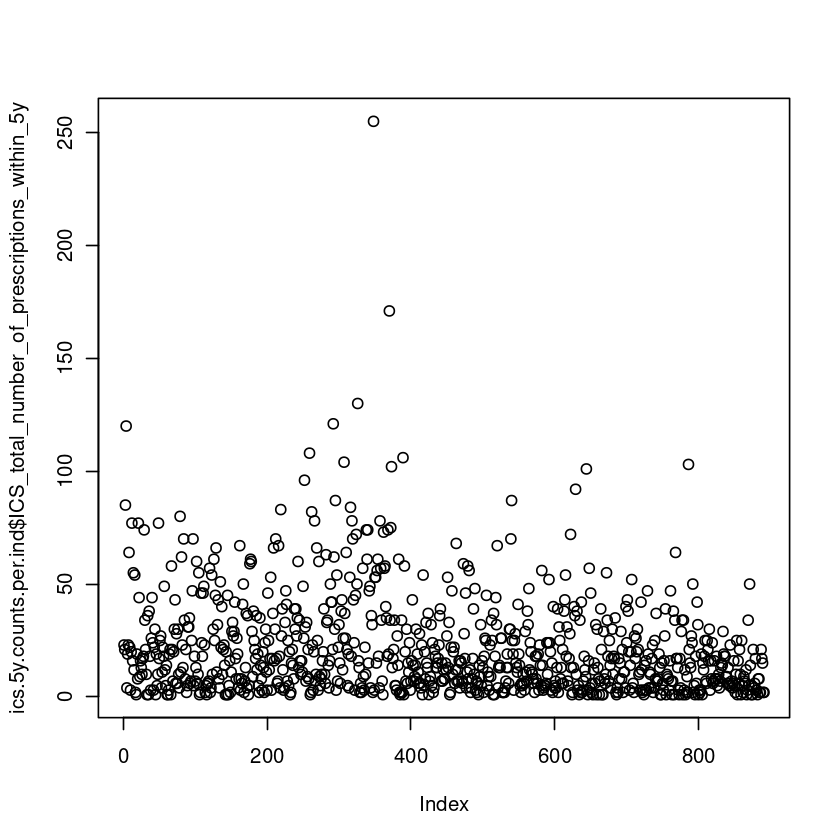

In [94]:
summary(ics.5y.counts.per.ind$ICS_total_number_of_prescriptions_within_5y)
plot(ics.5y.counts.per.ind$ICS_total_number_of_prescriptions_within_5y)

## ICS: Number of prescription within 5Y (before plasma collect date)

In [95]:
# create a dataset of no of prescriptions within 5 years before sample collection date
ics.5y.bef <- ics.med.group.w.date %>% filter(Days_Difference <= 1826 & Days_Difference >= 0)
dim(ics.5y.bef)

# check how many individuals have ICS prescriptions within the last 5 years based on sample collection date
length(unique(ics.5y.bef$Subject_Id)) # only 873 individuals

[1] 10654     7

[1] 873

In [96]:
summary(ics.5y.bef$Days_Difference)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   336.0   750.0   794.8  1232.8  1826.0 

In [97]:
# Group by Subject_Id and sum of medication date using dplyr
ics.5y.bef.counts.per.ind <- ics.5y.bef %>% group_by(Subject_Id) %>% 
  summarise(ICS_total_number_of_prescriptions_5y_bef_plasma_collect = sum(Prescription),
            .groups = 'drop')
dim(ics.5y.bef.counts.per.ind)

[1] 873   2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     3.0     7.0    12.2    17.0   125.0 

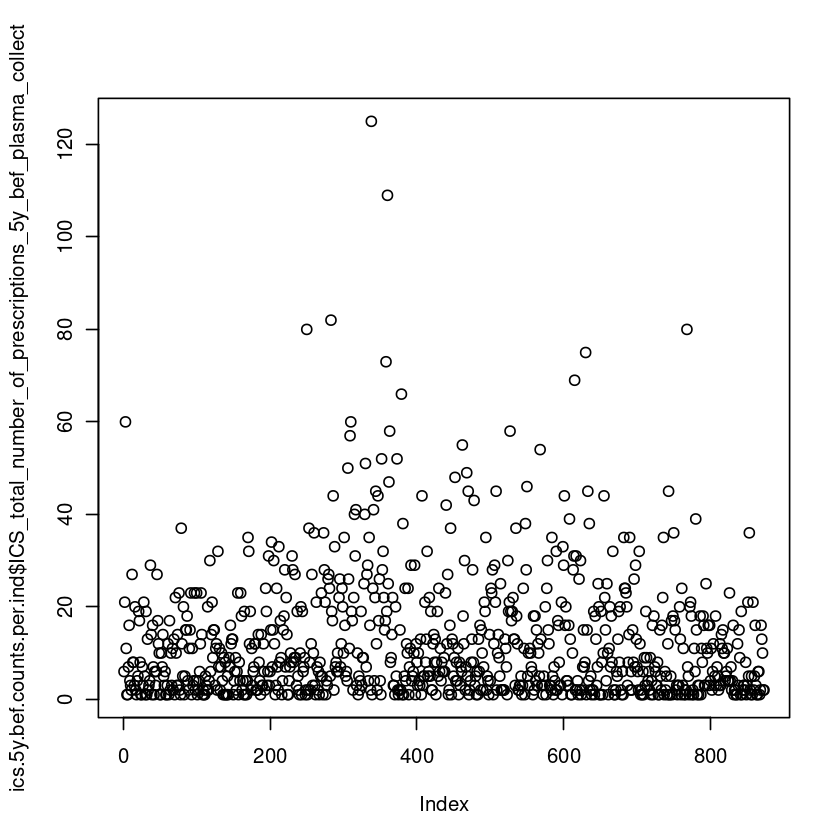

In [98]:
summary(ics.5y.bef.counts.per.ind$ICS_total_number_of_prescriptions_5y_bef_plasma_collect)
plot(ics.5y.bef.counts.per.ind$ICS_total_number_of_prescriptions_5y_bef_plasma_collect)

In [99]:
# merge
ics.presc.counts <- ics.prescr.counts.per.ind %>% left_join(ics.5y.bef.counts.per.ind, by = 'Subject_Id') %>%
                                                        left_join(ics.5y.counts.per.ind, by = 'Subject_Id')
dim(ics.presc.counts)

[1] 914   4

## ICS: Daily dose within 5Y (based on plasma collect date)

In [100]:
ics.active.chem <- ics.med.dose[,c('Med_common_name', 'Main_drug')]
ics.active.chem <- ics.active.chem[!duplicated(ics.active.chem),]
dim(ics.active.chem)

[1] 65  2

In [101]:
# merge
dim(ics.med.dose.max)
ics.med.dose.max <- ics.med.dose.max %>% left_join(ics.active.chem, 
                                                      by = 'Med_common_name')
dim(ics.med.dose.max)

[1] 24147     4

[1] 24147     5

In [102]:
# check active ingredient
table(ics.med.dose.max$Main_drug)


        Beclomethasone             Budesonide            Ciclesonide 
                   711                   4691                     53 
   Fluticasone furoate Fluticasone propionate             Mometasone 
                   153                  18377                    158 
         Triamcinolone 
                     4 

In [103]:
# Calculate date difference based on plasma collection date
ics.med.dose.max.w.date <- merge(ics.med.dose.max, data.id[,c('Subject_Id', 'Plasma_collect_date')], 
                              by = 'Subject_Id')
dim(ics.med.dose.max.w.date)

[1] 24147     6

In [104]:
# convert the date column to the Y-M-D format
ics.med.dose.max.w.date$Medication_Date <- as.Date(ics.med.dose.max.w.date$Medication_Date, format = "%m/%d/%Y")
typeof(ics.med.dose.max.w.date$Medication_Date)

# plasma collect date
ics.med.dose.max.w.date$Plasma_collect_date <- as.Date(ics.med.dose.max.w.date$Plasma_collect_date, format = "%Y -%m -%d")
typeof(ics.med.dose.max.w.date$Plasma_collect_date)

[1] "double"

[1] "double"

In [105]:
# substract collect date and diag date
ics.med.dose.max.w.date["Days_Difference"] <- difftime(ics.med.dose.max.w.date$Plasma_collect_date, 
                                                    ics.med.dose.max.w.date$Medication_Date, units = "days")
ics.med.dose.max.w.date$Days_Difference <- as.numeric(ics.med.dose.max.w.date$Days_Difference)
# absolute values
ics.med.dose.max.w.date["Days_Difference_Abs"] <- as.numeric(abs(ics.med.dose.max.w.date$Days_Difference))

In [106]:
typeof(ics.med.dose.max.w.date$Days_Difference)
typeof(ics.med.dose.max.w.date$Days_Difference_Abs)

[1] "double"

[1] "double"

In [107]:
# select 5 years only
ics.dose.5y <- ics.med.dose.max.w.date %>% filter(Days_Difference_Abs <= 1826)
dim(ics.dose.5y)
length(unique(ics.dose.5y$Subject_Id))

[1] 17867     8

[1] 863

In [108]:
table(ics.dose.5y$Main_drug)


        Beclomethasone             Budesonide            Ciclesonide 
                   550                   3608                     41 
   Fluticasone furoate Fluticasone propionate             Mometasone 
                    72                  13466                    130 

### 1. Beclomethasone

Low dose < 200 mcg/day
Medium dose >200 to 400 mcg/day
High dose >400 mcg/day

In [109]:
beclomethasone.5y <- ics.dose.5y %>% filter(Main_drug == 'Beclomethasone')
dim(beclomethasone.5y)
length(unique(beclomethasone.5y$Subject_Id)) # 68

[1] 550   8

[1] 68

In [110]:
typeof(beclomethasone.5y$Max_Daily_Dose_MCG)
summary(beclomethasone.5y$Max_Daily_Dose_MCG)

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   40.00   80.00   97.96   80.00  640.00 

In [111]:
# calculate median by Subject_Id
beclomethasone.5y.median <- beclomethasone.5y %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(beclomethasone.5y.median) <- c('Subject_Id', 'Beclomethasone_median_dose_5y')
dim(beclomethasone.5y.median)
length(unique(beclomethasone.5y.median$Subject_Id))

[1] 68  2

[1] 68

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   40.0    75.0    80.0   111.5   160.0   640.0 

1%   10%   25%   50%   75%   90%   99% 
 40.0  40.0  75.0  80.0 160.0 160.0 425.6

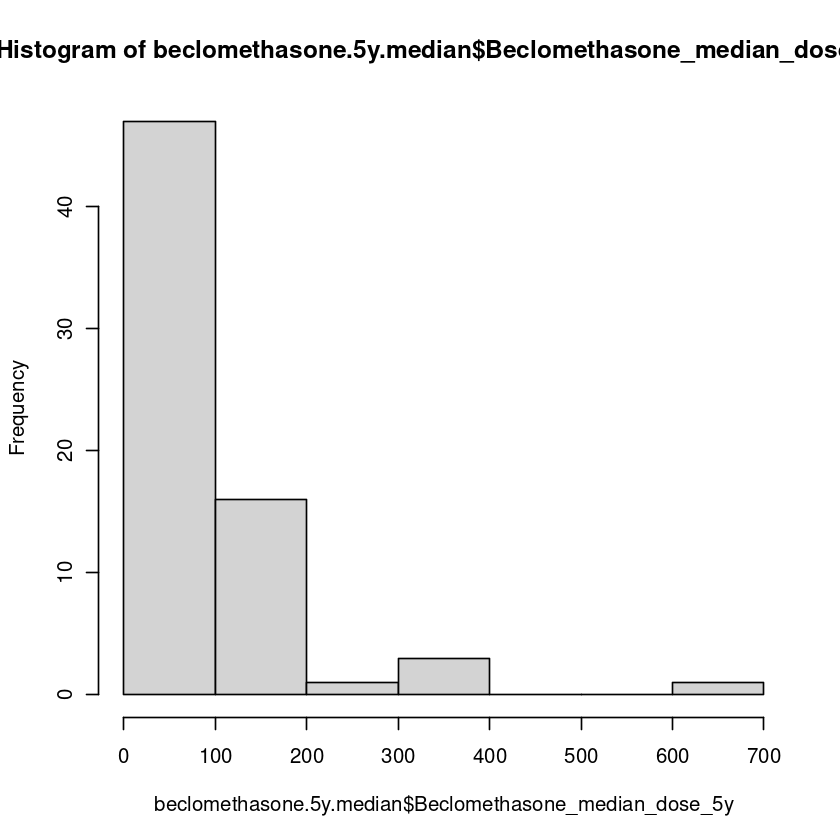

In [112]:
# check median dose result to see outliers
typeof(beclomethasone.5y.median$Beclomethasone_median_dose_5y)
summary(beclomethasone.5y.median$Beclomethasone_median_dose_5y)
quantile(beclomethasone.5y.median$Beclomethasone_median_dose_5y, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(beclomethasone.5y.median$Beclomethasone_median_dose_5y)

In [113]:
# classify dose: Low dose 100 to 200 mcg/day Medium dose >200 to 400 mcg/day High dose >400 mcg/day
beclomethasone.5y.median$Dose_Classification_Beclomethasone_5y <- NA
beclomethasone.5y.median$Dose_Classification_Beclomethasone_5y[beclomethasone.5y.median$Beclomethasone_median_dose_5y > 200] <- 'High_Medium_dose'
beclomethasone.5y.median$Dose_Classification_Beclomethasone_5y[beclomethasone.5y.median$Beclomethasone_median_dose_5y <= 200] <- 'Low_dose'
table(beclomethasone.5y.median$Dose_Classification_Beclomethasone_5y)


High_Medium_dose         Low_dose 
               5               63 

In [114]:
colSums(is.na(beclomethasone.5y.median))

Subject_Id         Beclomethasone_median_dose_5y 
                                    0                                     0 
Dose_Classification_Beclomethasone_5y 
                                    0

### 2. Budesonide

**Based on uptodate and GINA 2024**

Low dose: 200 to 400 mcg/day 
Medium dose: >400 to 800 mcg/day 
High dose: >800 mcg/day

In [115]:
budesonide.5y <- ics.dose.5y %>% filter(Main_drug == 'Budesonide')
dim(budesonide.5y)
length(unique(budesonide.5y$Subject_Id)) # 369

[1] 3608    8

[1] 369

In [116]:
typeof(budesonide.5y$Max_Daily_Dose_MCG)
summary(budesonide.5y$Max_Daily_Dose_MCG)

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     80     160     180     376     640    4000 

In [117]:
# calculate median by Subject_Id
budesonide.5y.median <- budesonide.5y %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(budesonide.5y.median) <- c('Subject_Id', 'Budesonide_median_dose_5y')
dim(budesonide.5y.median)
length(unique(budesonide.5y.median$Subject_Id))

[1] 369   2

[1] 369

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   80.0   160.0   320.0   392.5   640.0  4000.0 

1%  10%  25%  50%  75%  90%  99% 
  80   90  160  320  640  720 1000

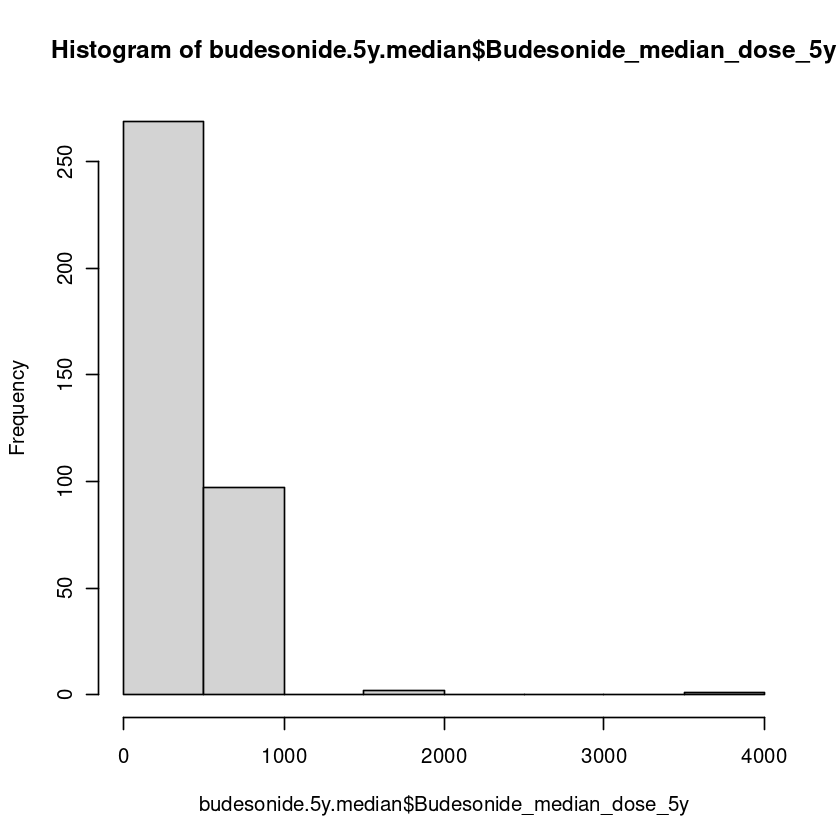

In [118]:
# check median dose result to see outliers
typeof(budesonide.5y.median$Budesonide_median_dose_5y)
summary(budesonide.5y.median$Budesonide_median_dose_5y)
quantile(budesonide.5y.median$Budesonide_median_dose_5y, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(budesonide.5y.median$Budesonide_median_dose_5y)

In [119]:
# classify dose: Low dose: 200 to 400 mcg/day Medium dose: >400 to 800 mcg/day High dose: >800 mcg/day
budesonide.5y.median$Dose_Classification_Budesonide_5y <- NA
budesonide.5y.median$Dose_Classification_Budesonide_5y[budesonide.5y.median$Budesonide_median_dose_5y > 400] <- 'High_Medium_dose'
budesonide.5y.median$Dose_Classification_Budesonide_5y[budesonide.5y.median$Budesonide_median_dose_5y <= 400] <- 'Low_dose'
table(budesonide.5y.median$Dose_Classification_Budesonide_5y)


High_Medium_dose         Low_dose 
             139              230 

In [120]:
colSums(is.na(budesonide.5y.median))

Subject_Id         Budesonide_median_dose_5y 
                                0                                 0 
Dose_Classification_Budesonide_5y 
                                0

### 3. Ciclesonide

In [121]:
ciclesonide.5y <- ics.dose.5y %>% filter(Main_drug == 'Ciclesonide')
dim(ciclesonide.5y)
length(unique(ciclesonide.5y$Subject_Id)) # 11

[1] 41  8

[1] 11

In [122]:
# calculate median by Subject_Id
ciclesonide.5y.median <- ciclesonide.5y %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(ciclesonide.5y.median) <- c('Subject_Id', 'Ciclesonide_median_dose_5y')
dim(ciclesonide.5y.median)
length(unique(ciclesonide.5y.median$Subject_Id))

[1] 11  2

[1] 11

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  160.0   320.0   640.0   581.8   640.0  1920.0 

1%  10%  25%  50%  75%  90%  99% 
 160  160  320  640  640  640 1792

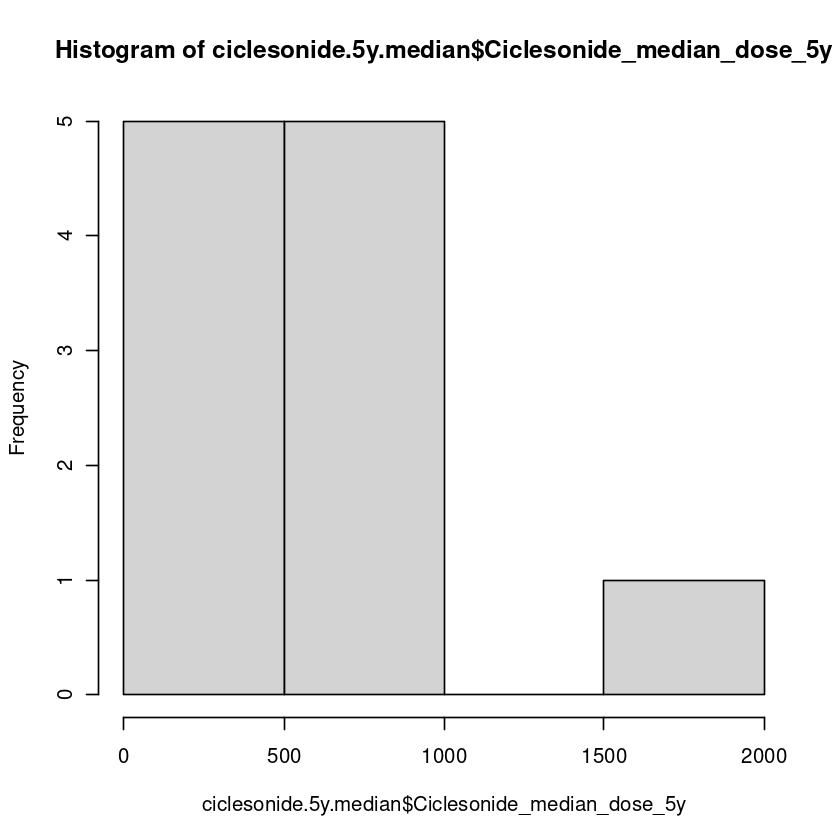

In [123]:
# check median dose result to see outliers
typeof(ciclesonide.5y.median$Ciclesonide_median_dose_5y)
summary(ciclesonide.5y.median$Ciclesonide_median_dose_5y)
quantile(ciclesonide.5y.median$Ciclesonide_median_dose_5y, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(ciclesonide.5y.median$Ciclesonide_median_dose_5y)

In [124]:
# classify dose: low dose: 80 to 160 mcg/day; medium dose >160 to 320 mcg/day; high dose >320 mcg/day
ciclesonide.5y.median$Dose_Classification_Ciclesonide_5y <- NA
ciclesonide.5y.median$Dose_Classification_Ciclesonide_5y[ciclesonide.5y.median$Ciclesonide_median_dose_5y > 160] <- 'High_Medium_dose'
ciclesonide.5y.median$Dose_Classification_Ciclesonide_5y[ciclesonide.5y.median$Ciclesonide_median_dose_5y <= 160] <- 'Low_dose'
table(ciclesonide.5y.median$Dose_Classification_Ciclesonide_5y)


High_Medium_dose         Low_dose 
               9                2 

In [125]:
colSums(is.na(ciclesonide.5y.median))

Subject_Id         Ciclesonide_median_dose_5y 
                                 0                                  0 
Dose_Classification_Ciclesonide_5y 
                                 0

### 4. Fluticasone furoate

In [126]:
fluticasone.furoate.5y <- ics.dose.5y %>% filter(Main_drug == 'Fluticasone furoate')
dim(fluticasone.furoate.5y)
length(unique(fluticasone.furoate.5y$Subject_Id)) # 33

[1] 72  8

[1] 33

In [127]:
# calculate median by Subject_Id
fluticasone.furoate.5y.median <- fluticasone.furoate.5y %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(fluticasone.furoate.5y.median) <- c('Subject_Id', 'Fluticasone_furoate_median_dose_5y')
dim(fluticasone.furoate.5y.median)
length(unique(fluticasone.furoate.5y.median$Subject_Id))

[1] 33  2

[1] 33

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   100.0   200.0   166.7   200.0   200.0 

1% 10% 25% 50% 75% 90% 99% 
100 100 100 200 200 200 200

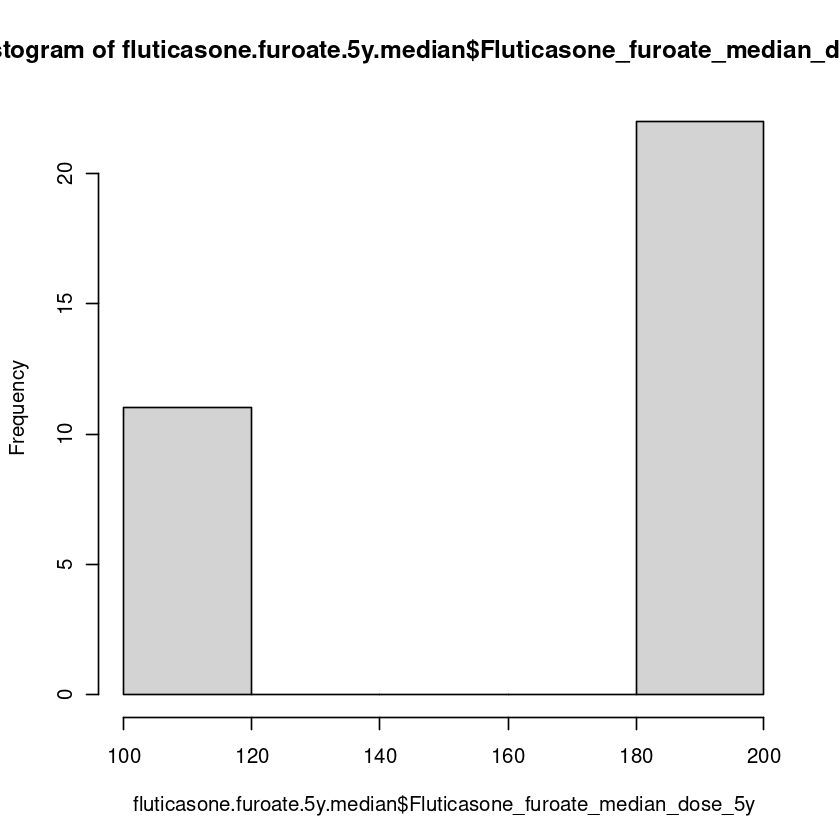

In [128]:
# check median dose result to see outliers
typeof(fluticasone.furoate.5y.median$Fluticasone_furoate_median_dose_5y)
summary(fluticasone.furoate.5y.median$Fluticasone_furoate_median_dose_5y)
quantile(fluticasone.furoate.5y.median$Fluticasone_furoate_median_dose_5y, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(fluticasone.furoate.5y.median$Fluticasone_furoate_median_dose_5y)

In [129]:
unique(fluticasone.furoate.5y.median$Fluticasone_furoate_median_dose_5y)

[1] 200 100

In [130]:
# classify dose: low dose: 100 mcg/day; high dose: 200 mcg/day
fluticasone.furoate.5y.median$Dose_Classification_Fluticasone_furoate_5y <- NA
fluticasone.furoate.5y.median$Dose_Classification_Fluticasone_furoate_5y[fluticasone.furoate.5y.median$Fluticasone_furoate_median_dose_5y == 200] <- 'High_Medium_dose'
fluticasone.furoate.5y.median$Dose_Classification_Fluticasone_furoate_5y[fluticasone.furoate.5y.median$Fluticasone_furoate_median_dose_5y == 100] <- 'Low_dose'
table(fluticasone.furoate.5y.median$Dose_Classification_Fluticasone_furoate_5y)


High_Medium_dose         Low_dose 
              22               11 

In [131]:
colSums(is.na(fluticasone.furoate.5y.median))

Subject_Id 
                                         0 
        Fluticasone_furoate_median_dose_5y 
                                         0 
Dose_Classification_Fluticasone_furoate_5y 
                                         0

### 5. Fluticasone propionate

**Based on uptodate and GINA 2024**

Low dose: 100 to 250 mcg/day	
Medium dose: >250 to 500 mcg/day	
High dose: >500 mcg/day	
Maximum 920 mcg/day

In [132]:
fluti.pro.5y <- ics.dose.5y %>% filter(Main_drug == 'Fluticasone propionate')
dim(fluti.pro.5y)
length(unique(fluti.pro.5y$Subject_Id)) # 777

[1] 13466     8

[1] 777

In [133]:
typeof(fluti.pro.5y$Max_Daily_Dose_MCG)
summary(fluti.pro.5y$Max_Daily_Dose_MCG)

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   44.0   200.0   250.0   396.4   500.0  2640.0 

In [134]:
# calculate median by Subject_Id
fluti.pro.5y.median <- fluti.pro.5y %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(fluti.pro.5y.median) <- c('Subject_Id', 'Fluticasone_propionate_median_dose_5y')
dim(fluti.pro.5y.median)
length(unique(fluti.pro.5y.median$Subject_Id))

[1] 777   2

[1] 777

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   44.0   150.0   250.0   317.5   500.0  1100.0 

1%  10%  25%  50%  75%  90%  99% 
  44  100  150  250  500  500 1000

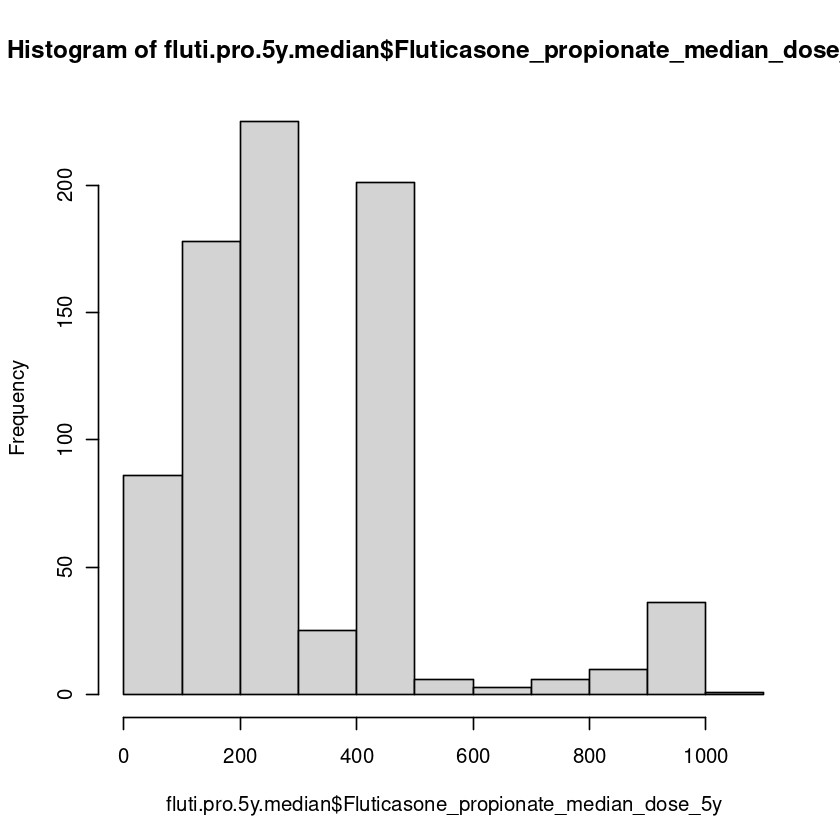

In [135]:
# check median dose result to see outliers
typeof(fluti.pro.5y.median$Fluticasone_propionate_median_dose_5y)
summary(fluti.pro.5y.median$Fluticasone_propionate_median_dose_5y)
quantile(fluti.pro.5y.median$Fluticasone_propionate_median_dose_5y, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(fluti.pro.5y.median$Fluticasone_propionate_median_dose_5y)

In [136]:
# classify dose: Low dose: 100 to 250 mcg/day; Medium dose and High > 250 mcg/day
fluti.pro.5y.median$Dose_Classification_Fluticasone_propionate_5y <- NA
fluti.pro.5y.median$Dose_Classification_Fluticasone_propionate_5y[fluti.pro.5y.median$Fluticasone_propionate_median_dose_5y > 250] <- 'High_Medium_dose'
fluti.pro.5y.median$Dose_Classification_Fluticasone_propionate_5y[fluti.pro.5y.median$Fluticasone_propionate_median_dose_5y <= 250] <- 'Low_dose'
table(fluti.pro.5y.median$Dose_Classification_Fluticasone_propionate_5y)


High_Medium_dose         Low_dose 
             292              485 

In [137]:
colSums(is.na(fluti.pro.5y.median))

Subject_Id 
                                            0 
        Fluticasone_propionate_median_dose_5y 
                                            0 
Dose_Classification_Fluticasone_propionate_5y 
                                            0

### 6. Mometasone

Low dose: 200 to 400 mcg/day
Medium dose: 200 to 400 mcg/day
High dose: >400 mcg/day

In [138]:
mometasone.5y <- ics.dose.5y %>% filter(Main_drug == 'Mometasone')
dim(mometasone.5y)
length(unique(mometasone.5y$Subject_Id)) # 56

[1] 130   8

[1] 56

In [139]:
# calculate median by Subject_Id
mometasone.5y.median <- mometasone.5y %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(mometasone.5y.median) <- c('Subject_Id', 'Mometasone_median_dose_5y')
dim(mometasone.5y.median)
length(unique(mometasone.5y.median$Subject_Id))

[1] 56  2

[1] 56

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   220.0   400.0   445.1   800.0   800.0 

1% 10% 25% 50% 75% 90% 99% 
100 155 220 400 800 800 800

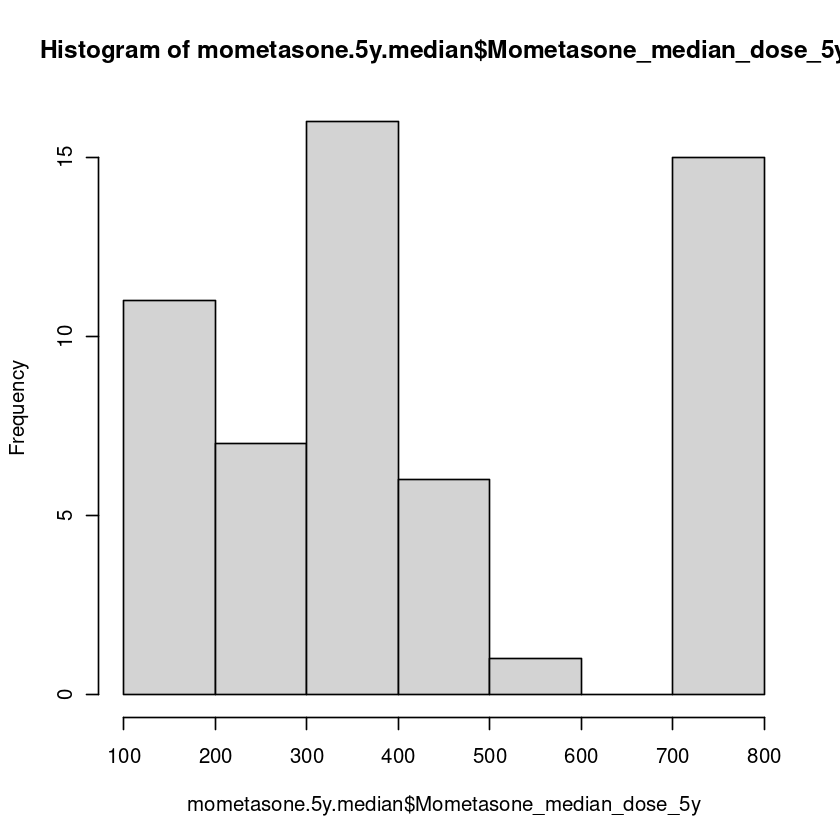

In [140]:
# check median dose result to see outliers
typeof(mometasone.5y.median$Mometasone_median_dose_5y)
summary(mometasone.5y.median$Mometasone_median_dose_5y)
quantile(mometasone.5y.median$Mometasone_median_dose_5y, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(mometasone.5y.median$Mometasone_median_dose_5y)

In [141]:
# classify dose: Low dose: 200 to 400 mcg/day Medium dose: 200 to 400 mcg/day High dose: >400 mcg/day
mometasone.5y.median$Dose_Classification_Mometasone_5y <- NA
mometasone.5y.median$Dose_Classification_Mometasone_5y[mometasone.5y.median$Mometasone_median_dose_5y > 400] <- 'High_Medium_dose'
mometasone.5y.median$Dose_Classification_Mometasone_5y[mometasone.5y.median$Mometasone_median_dose_5y <= 400] <- 'Low_dose'
table(mometasone.5y.median$Dose_Classification_Mometasone_5y)


High_Medium_dose         Low_dose 
              22               34 

In [142]:
# merge
dim(fluti.pro.5y.median) #1
dim(budesonide.5y.median) #2
dim(beclomethasone.5y.median) #3
dim(mometasone.5y.median) #4
dim(fluticasone.furoate.5y.median) #5
dim(ciclesonide.5y.median) #6

[1] 777   3

[1] 369   3

[1] 68  3

[1] 56  3

[1] 33  3

[1] 11  3

In [143]:
median.dose.5y.1 <- merge(fluti.pro.5y.median[,c('Subject_Id','Fluticasone_propionate_median_dose_5y',
                                           'Dose_Classification_Fluticasone_propionate_5y')],
                       budesonide.5y.median[,c('Subject_Id','Budesonide_median_dose_5y',
                                           'Dose_Classification_Budesonide_5y')], 
                       by = 'Subject_Id', all=T)
dim(fluti.pro.5y.median)
dim(budesonide.5y.median)
dim(median.dose.5y.1)

[1] 777   3

[1] 369   3

[1] 850   5

In [144]:
median.dose.5y.2 <- merge(beclomethasone.5y.median[,c('Subject_Id','Beclomethasone_median_dose_5y',
                                           'Dose_Classification_Beclomethasone_5y')],
                       mometasone.5y.median[,c('Subject_Id','Mometasone_median_dose_5y',
                                            'Dose_Classification_Mometasone_5y')], 
                       by = 'Subject_Id', all=T)
dim(beclomethasone.5y.median)
dim(mometasone.5y.median)
dim(median.dose.5y.2)

[1] 68  3

[1] 56  3

[1] 118   5

In [145]:
median.dose.5y.3 <- merge(ciclesonide.5y.median[,c('Subject_Id','Ciclesonide_median_dose_5y',
                                           'Dose_Classification_Ciclesonide_5y')],
                       fluticasone.furoate.5y.median[,c('Subject_Id','Fluticasone_furoate_median_dose_5y',
                                              'Dose_Classification_Fluticasone_furoate_5y')], 
                       by = 'Subject_Id', all=T)
dim(ciclesonide.5y.median)
dim(fluticasone.furoate.5y.median)
dim(median.dose.5y.3)

[1] 11  3

[1] 33  3

[1] 43  5

In [146]:
combined.median.dose.5y <- merge(median.dose.5y.1,median.dose.5y.2,by = 'Subject_Id', all=T)
dim(combined.median.dose.5y)
length(unique(combined.median.dose.5y$Subject_Id))

[1] 862   9

[1] 862

In [147]:
ics.daily.median.dose.5y <- merge(combined.median.dose.5y,median.dose.5y.3,by = 'Subject_Id', all=T)
dim(ics.daily.median.dose.5y)
length(unique(ics.daily.median.dose.5y$Subject_Id))

[1] 863  13

[1] 863

In [148]:
colSums(is.na(ics.daily.median.dose.5y))

Subject_Id 
                                            0 
        Fluticasone_propionate_median_dose_5y 
                                           86 
Dose_Classification_Fluticasone_propionate_5y 
                                           86 
                    Budesonide_median_dose_5y 
                                          494 
            Dose_Classification_Budesonide_5y 
                                          494 
                Beclomethasone_median_dose_5y 
                                          795 
        Dose_Classification_Beclomethasone_5y 
                                          795 
                    Mometasone_median_dose_5y 
                                          807 
            Dose_Classification_Mometasone_5y 
                                          807 
                   Ciclesonide_median_dose_5y 
                                          852 
           Dose_Classification_Ciclesonide_5y 
                                          852 
           Fluticasone_furoate_median_dose_5y 
                                          830 
   Dose_Classification_Fluticasone_furoate_5y 
                                          830

### ICS: Dose Category

In [149]:
# Select cols
median.dose.5y.group <- ics.daily.median.dose.5y %>% select(matches(c('Subject_Id','Dose_Classification')))
dim(median.dose.5y.group)

[1] 863   7

In [150]:
# check dose classifcation
dose.classify.cols <- colnames(median.dose.5y.group %>% select(matches('Dose_Classification')))
# summary statistic of diagnosis existence
for (i in c(1:length(dose.classify.cols))){
    print(dose.classify.cols[i])
    print(table(median.dose.5y.group[,dose.classify.cols[i]]))
}

[1] "Dose_Classification_Fluticasone_propionate_5y"

High_Medium_dose         Low_dose 
             292              485 
[1] "Dose_Classification_Budesonide_5y"

High_Medium_dose         Low_dose 
             139              230 
[1] "Dose_Classification_Beclomethasone_5y"

High_Medium_dose         Low_dose 
               5               63 
[1] "Dose_Classification_Mometasone_5y"

High_Medium_dose         Low_dose 
              22               34 
[1] "Dose_Classification_Ciclesonide_5y"

High_Medium_dose         Low_dose 
               9                2 
[1] "Dose_Classification_Fluticasone_furoate_5y"

High_Medium_dose         Low_dose 
              22               11 


In [151]:
# replace low dose is 1 and high medium dose is 2
median.dose.5y.group[median.dose.5y.group == 'Low_dose'] <- '1'
median.dose.5y.group[median.dose.5y.group == 'High_Medium_dose'] <- '2'

In [152]:
for (i in c(1:length(dose.classify.cols))){
    print(dose.classify.cols[i])
    print(table(median.dose.5y.group[,dose.classify.cols[i]]))
}

[1] "Dose_Classification_Fluticasone_propionate_5y"

  1   2 
485 292 
[1] "Dose_Classification_Budesonide_5y"

  1   2 
230 139 
[1] "Dose_Classification_Beclomethasone_5y"

 1  2 
63  5 
[1] "Dose_Classification_Mometasone_5y"

 1  2 
34 22 
[1] "Dose_Classification_Ciclesonide_5y"

1 2 
2 9 
[1] "Dose_Classification_Fluticasone_furoate_5y"

 1  2 
11 22 


In [153]:
# change numeric
for (col in dose.classify.cols){
    median.dose.5y.group[[col]] <- as.numeric(median.dose.5y.group[[col]])
}

In [154]:
median.dose.5y.group$ICS_Dose_Classification_5Y_Median <- apply(median.dose.5y.group[,c(2:7)], 1, median, na.rm = TRUE)
head(median.dose.5y.group$ICS_Dose_Classification_5Y_Median)

[1] 1.0 2.0 1.5 1.0 2.0 1.0

In [155]:
table(median.dose.5y.group$ICS_Dose_Classification_5Y_Median)
summary(median.dose.5y.group$ICS_Dose_Classification_5Y_Median)


  1 1.5   2 
495 121 247 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.356   2.000   2.000 

In [156]:
median.dose.5y.group <- median.dose.5y.group %>% select(Subject_Id, ICS_Dose_Classification_5Y_Median)

In [157]:
dim(median.dose.5y.group)

[1] 863   2

## ICS: Daily dose 5Y before plasma collect date

In [158]:
# select 5 years before plasma collect date
ics.dose.5y.bef <- ics.med.dose.max.w.date %>% filter(Days_Difference <= 1826 & Days_Difference >= 0)
dim(ics.dose.5y.bef)
length(unique(ics.dose.5y.bef$Subject_Id)) # 816

[1] 9714    8

[1] 816

In [159]:
# check how many individuals have ICS prescriptions within the last 5 years based on sample collection date
length(unique(ics.5y.bef$Subject_Id)) # only 873 individuals

[1] 873

In [160]:
length(unique((filter(ics.dose.5y.bef, Subject_Id %in% ics.5y.bef$Subject_Id))$Subject_Id))

[1] 816

In [161]:
summary(ics.dose.5y.bef$Days_Difference)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   331.0   743.0   789.2  1222.0  1826.0 

In [162]:
table(ics.dose.5y.bef$Main_drug)


        Beclomethasone             Budesonide            Ciclesonide 
                   324                   1686                      9 
   Fluticasone furoate Fluticasone propionate             Mometasone 
                    11                   7636                     48 

### 1. Beclomethasone

Low dose < 200 mcg/day
Medium dose >200 to 400 mcg/day
High dose >400 mcg/day

In [163]:
beclomethasone.5y.bef <- ics.dose.5y.bef %>% filter(Main_drug == 'Beclomethasone')
dim(beclomethasone.5y.bef)
length(unique(beclomethasone.5y.bef$Subject_Id)) # 46

[1] 324   8

[1] 46

In [164]:
typeof(beclomethasone.5y.bef$Max_Daily_Dose_MCG)
summary(beclomethasone.5y.bef$Max_Daily_Dose_MCG)

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   40.0    40.0    80.0    78.4    80.0   640.0 

In [165]:
# calculate median by Subject_Id
beclomethasone.5y.bef.median <- beclomethasone.5y.bef %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(beclomethasone.5y.bef.median) <- c('Subject_Id', 'Beclomethasone_median_dose_5y_bef')
dim(beclomethasone.5y.bef.median)
length(unique(beclomethasone.5y.bef.median$Subject_Id))

[1] 46  2

[1] 46

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   40.00   80.00   88.26   80.00  640.00 

1% 10% 25% 50% 75% 90% 99% 
 40  40  40  80  80 160 424

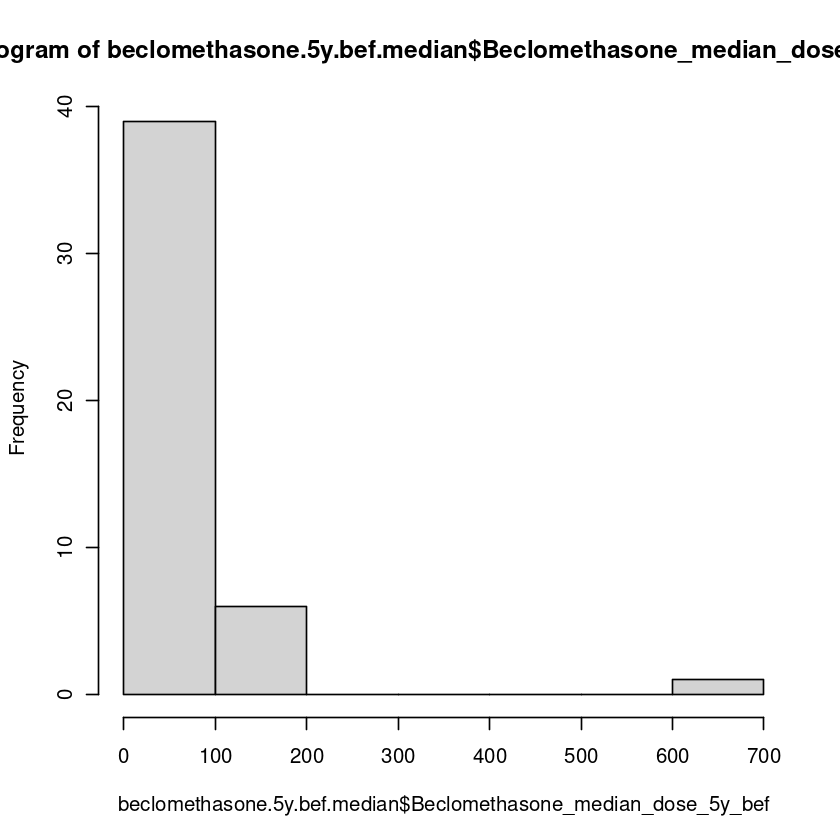

In [166]:
# check median dose result to see outliers
typeof(beclomethasone.5y.bef.median$Beclomethasone_median_dose_5y_bef)
summary(beclomethasone.5y.bef.median$Beclomethasone_median_dose_5y_bef)
quantile(beclomethasone.5y.bef.median$Beclomethasone_median_dose_5y_bef, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(beclomethasone.5y.bef.median$Beclomethasone_median_dose_5y_bef)

In [167]:
# classify dose: Low dose 100 to 200 mcg/day Medium dose >200 to 400 mcg/day High dose >400 mcg/day
beclomethasone.5y.bef.median$Dose_Classification_Beclomethasone_5y_bef <- NA
beclomethasone.5y.bef.median$Dose_Classification_Beclomethasone_5y_bef[beclomethasone.5y.bef.median$Beclomethasone_median_dose_5y_bef > 200] <- 'High_Medium_dose'
beclomethasone.5y.bef.median$Dose_Classification_Beclomethasone_5y_bef[beclomethasone.5y.bef.median$Beclomethasone_median_dose_5y_bef <= 200] <- 'Low_dose'
table(beclomethasone.5y.bef.median$Dose_Classification_Beclomethasone_5y_bef)


High_Medium_dose         Low_dose 
               1               45 

### 2. Budesonide

**Based on uptodate and GINA 2024**

Low dose: 200 to 400 mcg/day 
Medium dose: >400 to 800 mcg/day 
High dose: >800 mcg/day

In [168]:
budesonide.5y.bef <- ics.dose.5y.bef %>% filter(Main_drug == 'Budesonide')
dim(budesonide.5y.bef)
length(unique(budesonide.5y.bef$Subject_Id)) # 236

[1] 1686    8

[1] 236

In [169]:
typeof(budesonide.5y.bef$Max_Daily_Dose_MCG)
summary(budesonide.5y.bef$Max_Daily_Dose_MCG)

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   80.0   160.0   180.0   313.1   360.0  2160.0 

In [170]:
# calculate median by Subject_Id
budesonide.5y.bef.median <- budesonide.5y.bef %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(budesonide.5y.bef.median) <- c('Subject_Id', 'Budesonide_median_dose_5y_bef')
dim(budesonide.5y.bef.median)
length(unique(budesonide.5y.bef.median$Subject_Id))

[1] 236   2

[1] 236

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   80.0   160.0   180.0   327.1   450.0  1500.0 

1%  10%  25%  50%  75%  90%  99% 
  80   85  160  180  450  640 1000

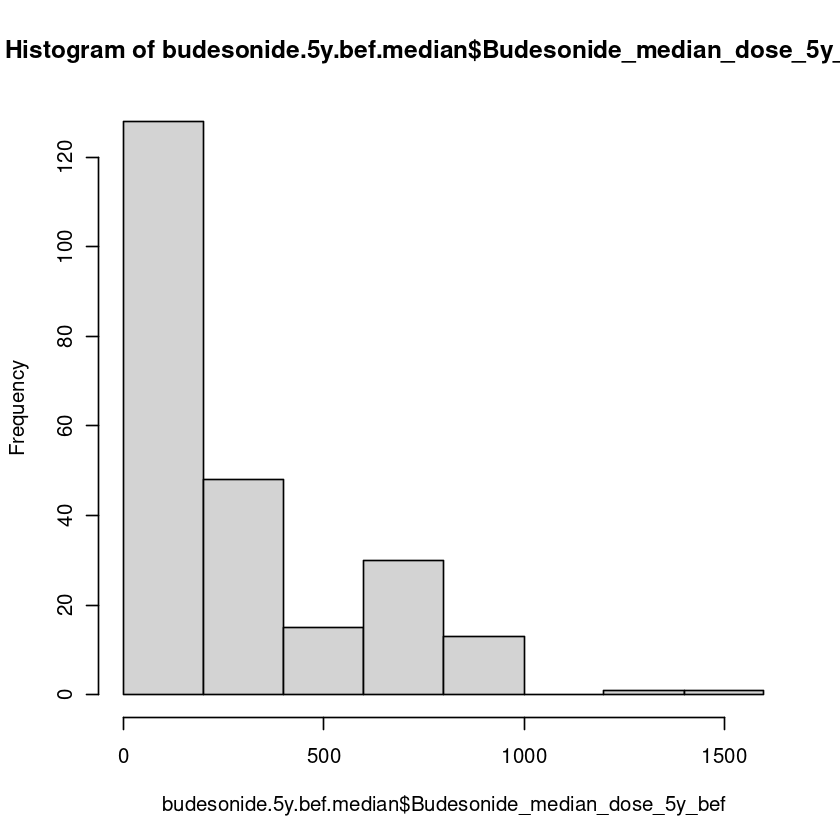

In [171]:
# check median dose result to see outliers
typeof(budesonide.5y.bef.median$Budesonide_median_dose_5y_bef)
summary(budesonide.5y.bef.median$Budesonide_median_dose_5y_bef)
quantile(budesonide.5y.bef.median$Budesonide_median_dose_5y_bef, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(budesonide.5y.bef.median$Budesonide_median_dose_5y_bef)

In [172]:
# classify dose: Low dose: 200 to 400 mcg/day Medium dose: >400 to 800 mcg/day High dose: >800 mcg/day
budesonide.5y.bef.median$Dose_Classification_Budesonide_5y_bef <- NA
budesonide.5y.bef.median$Dose_Classification_Budesonide_5y_bef[budesonide.5y.bef.median$Budesonide_median_dose_5y_bef > 400] <- 'High_Medium_dose'
budesonide.5y.bef.median$Dose_Classification_Budesonide_5y_bef[budesonide.5y.bef.median$Budesonide_median_dose_5y_bef <= 400] <- 'Low_dose'
table(budesonide.5y.bef.median$Dose_Classification_Budesonide_5y_bef)


High_Medium_dose         Low_dose 
              60              176 

### 3. Ciclesonide

In [173]:
ciclesonide.5y.bef <- ics.dose.5y.bef %>% filter(Main_drug == 'Ciclesonide')
dim(ciclesonide.5y.bef)
length(unique(ciclesonide.5y.bef$Subject_Id)) # 4

[1] 9 8

[1] 4

In [174]:
# calculate median by Subject_Id
ciclesonide.5y.bef.median <- ciclesonide.5y.bef %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(ciclesonide.5y.bef.median) <- c('Subject_Id', 'Ciclesonide_median_dose_5y_bef')
dim(ciclesonide.5y.bef.median)
length(unique(ciclesonide.5y.bef.median$Subject_Id))

[1] 4 2

[1] 4

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    160     280     320     680     720    1920 

1%    10%    25%    50%    75%    90%    99% 
 164.8  208.0  280.0  320.0  720.0 1440.0 1872.0

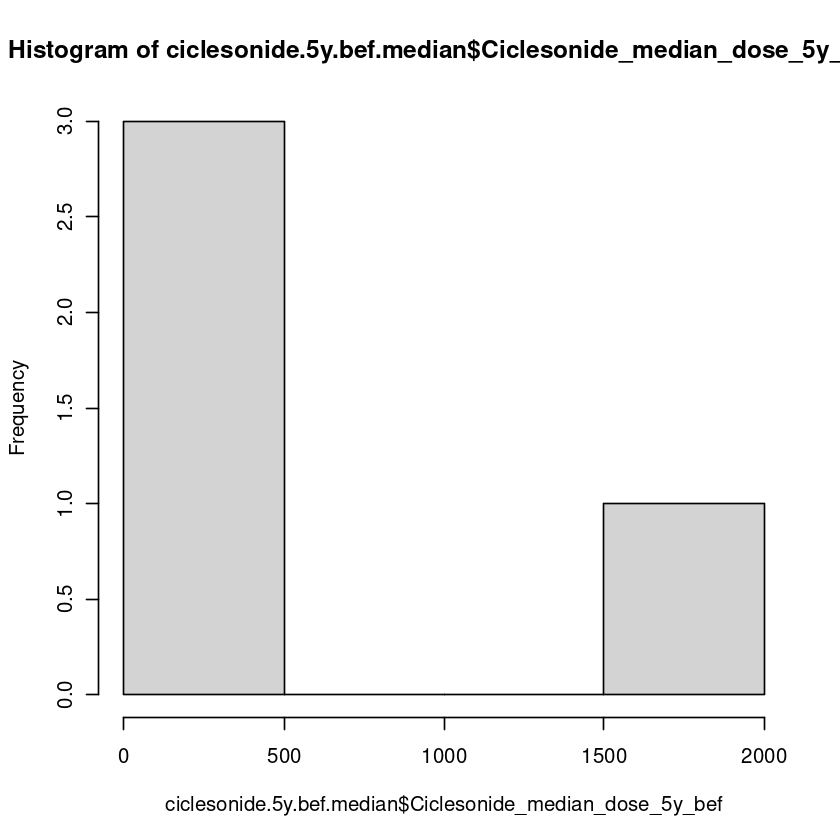

In [175]:
# check median dose result to see outliers
typeof(ciclesonide.5y.bef.median$Ciclesonide_median_dose_5y_bef)
summary(ciclesonide.5y.bef.median$Ciclesonide_median_dose_5y_bef)
quantile(ciclesonide.5y.bef.median$Ciclesonide_median_dose_5y_bef, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(ciclesonide.5y.bef.median$Ciclesonide_median_dose_5y_bef)

In [176]:
# classify dose: low dose: 80 to 160 mcg/day; medium dose >160 to 320 mcg/day; high dose >320 mcg/day
ciclesonide.5y.bef.median$Dose_Classification_Ciclesonide_5y_bef <- NA
ciclesonide.5y.bef.median$Dose_Classification_Ciclesonide_5y_bef[ciclesonide.5y.bef.median$Ciclesonide_median_dose_5y_bef > 160] <- 'High_Medium_dose'
ciclesonide.5y.bef.median$Dose_Classification_Ciclesonide_5y_bef[ciclesonide.5y.bef.median$Ciclesonide_median_dose_5y_bef <= 160] <- 'Low_dose'
table(ciclesonide.5y.bef.median$Dose_Classification_Ciclesonide_5y_bef)


High_Medium_dose         Low_dose 
               3                1 

### 4. Fluticasone furoate

In [177]:
fluticasone.furoate.5y.bef <- ics.dose.5y.bef %>% filter(Main_drug == 'Fluticasone furoate')
dim(fluticasone.furoate.5y.bef)
length(unique(fluticasone.furoate.5y.bef$Subject_Id)) # 8

[1] 11  8

[1] 8

In [178]:
# calculate median by Subject_Id
fluticasone.furoate.5y.bef.median <- fluticasone.furoate.5y.bef %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(fluticasone.furoate.5y.bef.median) <- c('Subject_Id', 'Fluticasone_furoate_median_dose_5y_bef')
dim(fluticasone.furoate.5y.bef.median)
length(unique(fluticasone.furoate.5y.bef.median$Subject_Id))

[1] 8 2

[1] 8

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   200.0   200.0   187.5   200.0   200.0 

1% 10% 25% 50% 75% 90% 99% 
107 170 200 200 200 200 200

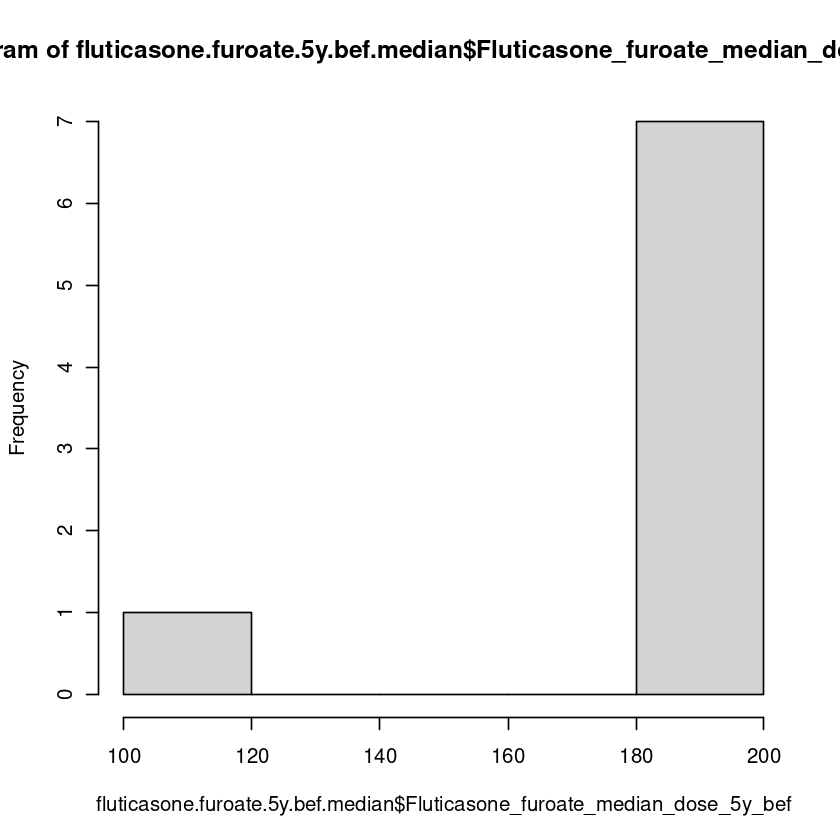

In [179]:
# check median dose result to see outliers
typeof(fluticasone.furoate.5y.bef.median$Fluticasone_furoate_median_dose_5y_bef)
summary(fluticasone.furoate.5y.bef.median$Fluticasone_furoate_median_dose_5y_bef)
quantile(fluticasone.furoate.5y.bef.median$Fluticasone_furoate_median_dose_5y_bef, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(fluticasone.furoate.5y.bef.median$Fluticasone_furoate_median_dose_5y_bef)

In [180]:
unique(fluticasone.furoate.5y.bef.median$Fluticasone_furoate_median_dose_5y_bef)

[1] 100 200

In [181]:
# classify dose: low dose: 100 mcg/day; high dose: 200 mcg/day
fluticasone.furoate.5y.bef.median$Dose_Classification_Fluticasone_furoate_5y_bef <- NA
fluticasone.furoate.5y.bef.median$Dose_Classification_Fluticasone_furoate_5y_bef[fluticasone.furoate.5y.bef.median$Fluticasone_furoate_median_dose_5y_bef == 200] <- 'High_Medium_dose'
fluticasone.furoate.5y.bef.median$Dose_Classification_Fluticasone_furoate_5y_bef[fluticasone.furoate.5y.bef.median$Fluticasone_furoate_median_dose_5y_bef == 100] <- 'Low_dose'
table(fluticasone.furoate.5y.bef.median$Dose_Classification_Fluticasone_furoate_5y_bef)


High_Medium_dose         Low_dose 
               7                1 

### 5. Fluticasone propionate

**Based on uptodate and GINA 2024**

Low dose: 100 to 250 mcg/day	
Medium dose: >250 to 500 mcg/day	
High dose: >500 mcg/day	
Maximum 920 mcg/day

In [182]:
fluti.pro.5y.bef <- ics.dose.5y.bef %>% filter(Main_drug == 'Fluticasone propionate')
dim(fluti.pro.5y.bef)
length(unique(fluti.pro.5y.bef$Subject_Id)) # 707

[1] 7636    8

[1] 707

In [183]:
# calculate median by Subject_Id
fluti.pro.5y.bef.median <- fluti.pro.5y.bef %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(fluti.pro.5y.bef.median) <- c('Subject_Id', 'Fluticasone_propionate_median_dose_5y_bef')
dim(fluti.pro.5y.bef.median)
length(unique(fluti.pro.5y.bef.median$Subject_Id))

[1] 707   2

[1] 707

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   44.0   110.0   230.0   302.7   500.0  1100.0 

1%  10%  25%  50%  75%  90%  99% 
  44  100  110  230  500  500 1000

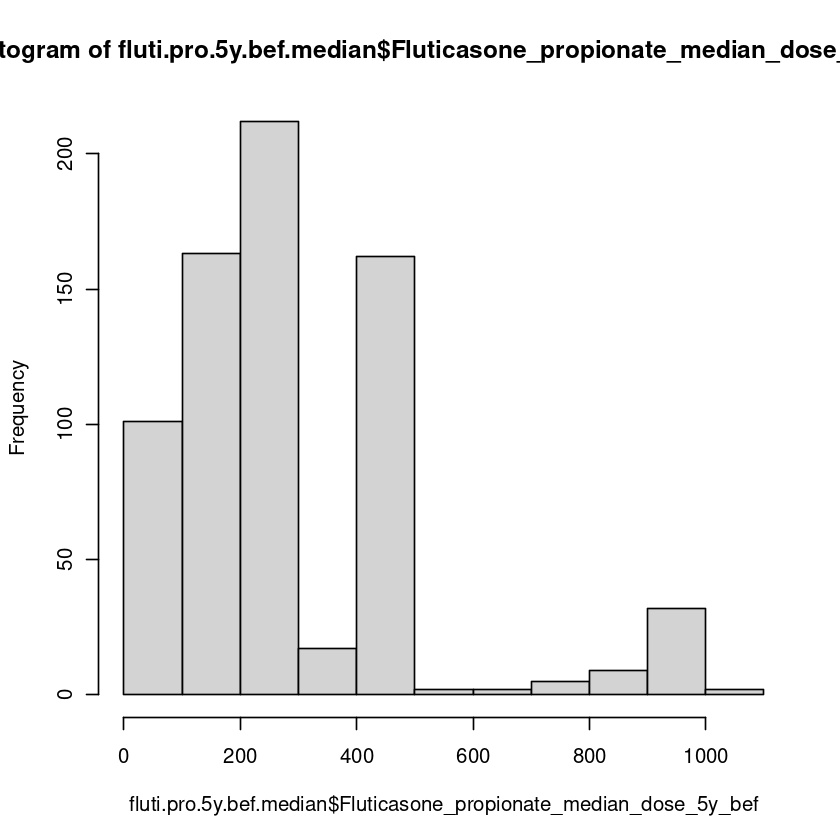

In [184]:
# check median dose result to see outliers
typeof(fluti.pro.5y.bef.median$Fluticasone_propionate_median_dose_5y_bef)
summary(fluti.pro.5y.bef.median$Fluticasone_propionate_median_dose_5y_bef)
quantile(fluti.pro.5y.bef.median$Fluticasone_propionate_median_dose_5y_bef, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(fluti.pro.5y.bef.median$Fluticasone_propionate_median_dose_5y_bef)

In [185]:
# classify dose: Low dose: 100 to 250 mcg/day; Medium dose and High > 250 mcg/day
fluti.pro.5y.bef.median$Dose_Classification_Fluticasone_propionate_5y_bef <- NA
fluti.pro.5y.bef.median$Dose_Classification_Fluticasone_propionate_5y_bef[fluti.pro.5y.bef.median$Fluticasone_propionate_median_dose_5y_bef > 250] <- 'High_Medium_dose'
fluti.pro.5y.bef.median$Dose_Classification_Fluticasone_propionate_5y_bef[fluti.pro.5y.bef.median$Fluticasone_propionate_median_dose_5y_bef <= 250] <- 'Low_dose'
table(fluti.pro.5y.bef.median$Dose_Classification_Fluticasone_propionate_5y_bef)


High_Medium_dose         Low_dose 
             238              469 

### 6. Mometasone

Low dose: 200 to 400 mcg/day
Medium dose: 200 to 400 mcg/day
High dose: >400 mcg/day

In [186]:
mometasone.5y.bef <- ics.dose.5y.bef %>% filter(Main_drug == 'Mometasone')
dim(mometasone.5y.bef)
length(unique(mometasone.5y.bef$Subject_Id)) # 30

[1] 48  8

[1] 30

In [187]:
# calculate median by Subject_Id
mometasone.5y.bef.median <- mometasone.5y.bef %>% group_by(Subject_Id) %>% 
                                 summarise_at(vars('Max_Daily_Dose_MCG'), c(median))
colnames(mometasone.5y.bef.median) <- c('Subject_Id', 'Mometasone_median_dose_5y_bef')
dim(mometasone.5y.bef.median)
length(unique(mometasone.5y.bef.median$Subject_Id))

[1] 30  2

[1] 30

[1] "double"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   220.0   400.0   445.1   800.0   800.0 

1% 10% 25% 50% 75% 90% 99% 
100 155 220 400 800 800 800

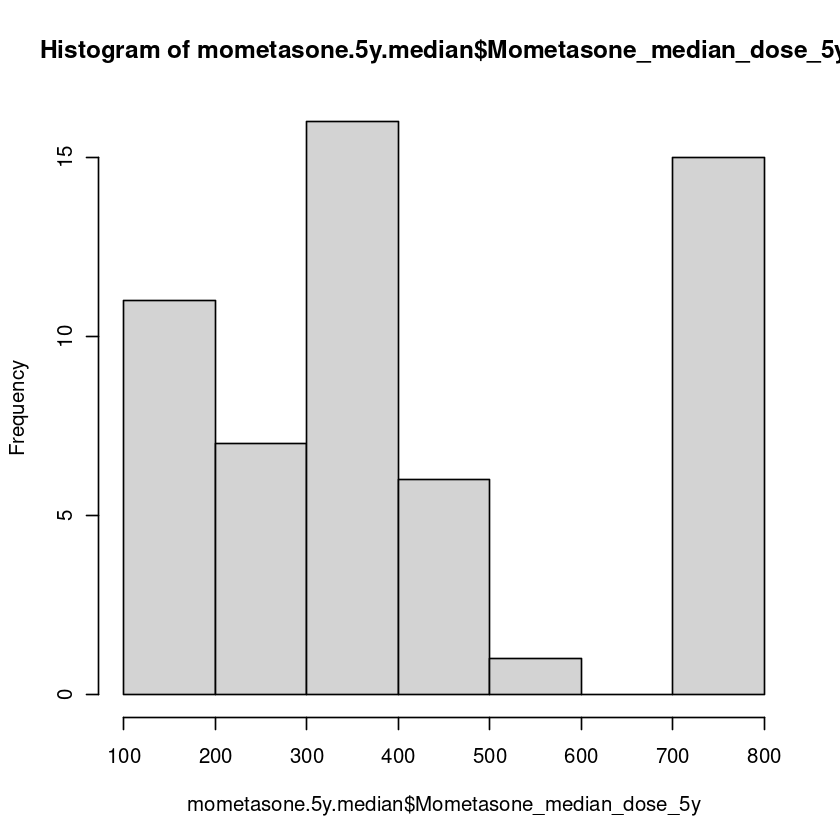

In [188]:
# check median dose result to see outliers
typeof(mometasone.5y.median$Mometasone_median_dose_5y)
summary(mometasone.5y.median$Mometasone_median_dose_5y)
quantile(mometasone.5y.median$Mometasone_median_dose_5y, c(.01,.1,.25,.50,.75,.90,.99), na.rm = TRUE)
hist(mometasone.5y.median$Mometasone_median_dose_5y)

In [189]:
# classify dose: Low dose: 200 to 400 mcg/day Medium dose: 200 to 400 mcg/day High dose: >400 mcg/day
mometasone.5y.bef.median$Dose_Classification_Mometasone_5y_bef <- NA
mometasone.5y.bef.median$Dose_Classification_Mometasone_5y_bef[mometasone.5y.bef.median$Mometasone_median_dose_5y_bef > 400] <- 'High_Medium_dose'
mometasone.5y.bef.median$Dose_Classification_Mometasone_5y_bef[mometasone.5y.bef.median$Mometasone_median_dose_5y_bef <= 400] <- 'Low_dose'
table(mometasone.5y.bef.median$Dose_Classification_Mometasone_5y_bef)


High_Medium_dose         Low_dose 
              12               18 

In [190]:
# merge
dim(mometasone.5y.bef.median)
dim(fluti.pro.5y.bef.median)
dim(fluticasone.furoate.5y.bef.median)

dim(ciclesonide.5y.bef.median)
dim(budesonide.5y.bef.median)
dim(beclomethasone.5y.bef.median)

[1] 30  3

[1] 707   3

[1] 8 3

[1] 4 3

[1] 236   3

[1] 46  3

In [191]:
median.dose.5y.bef.1 <- merge(fluti.pro.5y.bef.median[,c('Subject_Id','Fluticasone_propionate_median_dose_5y_bef',
                                           'Dose_Classification_Fluticasone_propionate_5y_bef')],
                       budesonide.5y.bef.median[,c('Subject_Id','Budesonide_median_dose_5y_bef',
                                           'Dose_Classification_Budesonide_5y_bef')], 
                       by = 'Subject_Id', all=T)
dim(fluti.pro.5y.bef.median)
dim(budesonide.5y.bef.median)
dim(median.dose.5y.bef.1)

[1] 707   3

[1] 236   3

[1] 795   5

In [192]:
median.dose.5y.bef.2 <- merge(beclomethasone.5y.bef.median[,c('Subject_Id','Beclomethasone_median_dose_5y_bef',
                                           'Dose_Classification_Beclomethasone_5y_bef')],
                       mometasone.5y.bef.median[,c('Subject_Id','Mometasone_median_dose_5y_bef',
                                            'Dose_Classification_Mometasone_5y_bef')], 
                       by = 'Subject_Id', all=T)
dim(beclomethasone.5y.bef.median)
dim(mometasone.5y.bef.median)
dim(median.dose.5y.bef.2)

[1] 46  3

[1] 30  3

[1] 75  5

In [193]:
median.dose.5y.bef.3 <- merge(ciclesonide.5y.bef.median[,c('Subject_Id','Ciclesonide_median_dose_5y_bef',
                                           'Dose_Classification_Ciclesonide_5y_bef')],
                       fluticasone.furoate.5y.bef.median[,c('Subject_Id','Fluticasone_furoate_median_dose_5y_bef',
                                              'Dose_Classification_Fluticasone_furoate_5y_bef')], 
                       by = 'Subject_Id', all=T)
dim(ciclesonide.5y.bef.median)
dim(fluticasone.furoate.5y.bef.median)
dim(median.dose.5y.bef.3)

[1] 4 3

[1] 8 3

[1] 12  5

In [194]:
combined.median.dose.5y.bef <- merge(median.dose.5y.bef.1,median.dose.5y.bef.2,by = 'Subject_Id', all=T)
dim(combined.median.dose.5y.bef)
length(unique(combined.median.dose.5y.bef$Subject_Id))

[1] 814   9

[1] 814

In [195]:
ics.daily.median.dose.5y.bef <- merge(combined.median.dose.5y.bef,median.dose.5y.bef.3,by = 'Subject_Id', all=T)
dim(ics.daily.median.dose.5y.bef)
length(unique(ics.daily.median.dose.5y.bef$Subject_Id))

[1] 816  13

[1] 816

In [196]:
colSums(is.na(ics.daily.median.dose.5y.bef))

Subject_Id 
                                                0 
        Fluticasone_propionate_median_dose_5y_bef 
                                              109 
Dose_Classification_Fluticasone_propionate_5y_bef 
                                              109 
                    Budesonide_median_dose_5y_bef 
                                              580 
            Dose_Classification_Budesonide_5y_bef 
                                              580 
                Beclomethasone_median_dose_5y_bef 
                                              770 
        Dose_Classification_Beclomethasone_5y_bef 
                                              770 
                    Mometasone_median_dose_5y_bef 
                                              786 
            Dose_Classification_Mometasone_5y_bef 
                                              786 
                   Ciclesonide_median_dose_5y_bef 
                                              812 
           Dose_Classification_Ciclesonide_5y_bef 
                                              812 
           Fluticasone_furoate_median_dose_5y_bef 
                                              808 
   Dose_Classification_Fluticasone_furoate_5y_bef 
                                              808

### ICS: Dose Category

In [197]:
# Select cols
median.dose.5y.bef.group <- ics.daily.median.dose.5y.bef %>% select(matches(c('Subject_Id','Dose_Classification')))
dim(median.dose.5y.bef.group)

[1] 816   7

In [198]:
# check dose classifcation
dose.classify.cols <- colnames(median.dose.5y.bef.group %>% select(matches('Dose_Classification')))
# summary statistic of diagnosis existence
for (i in c(1:length(dose.classify.cols))){
    print(dose.classify.cols[i])
    print(table(median.dose.5y.bef.group[,dose.classify.cols[i]]))
}

[1] "Dose_Classification_Fluticasone_propionate_5y_bef"

High_Medium_dose         Low_dose 
             238              469 
[1] "Dose_Classification_Budesonide_5y_bef"

High_Medium_dose         Low_dose 
              60              176 
[1] "Dose_Classification_Beclomethasone_5y_bef"

High_Medium_dose         Low_dose 
               1               45 
[1] "Dose_Classification_Mometasone_5y_bef"

High_Medium_dose         Low_dose 
              12               18 
[1] "Dose_Classification_Ciclesonide_5y_bef"

High_Medium_dose         Low_dose 
               3                1 
[1] "Dose_Classification_Fluticasone_furoate_5y_bef"

High_Medium_dose         Low_dose 
               7                1 


In [199]:
# replace low dose is 1 and high medium dose is 2
median.dose.5y.bef.group[median.dose.5y.bef.group == 'Low_dose'] <- '1'
median.dose.5y.bef.group[median.dose.5y.bef.group == 'High_Medium_dose'] <- '2'

In [200]:
for (i in c(1:length(dose.classify.cols))){
    print(dose.classify.cols[i])
    print(table(median.dose.5y.bef.group[,dose.classify.cols[i]]))
}

[1] "Dose_Classification_Fluticasone_propionate_5y_bef"

  1   2 
469 238 
[1] "Dose_Classification_Budesonide_5y_bef"

  1   2 
176  60 
[1] "Dose_Classification_Beclomethasone_5y_bef"

 1  2 
45  1 
[1] "Dose_Classification_Mometasone_5y_bef"

 1  2 
18 12 
[1] "Dose_Classification_Ciclesonide_5y_bef"

1 2 
1 3 
[1] "Dose_Classification_Fluticasone_furoate_5y_bef"

1 2 
1 7 


In [201]:
# change numeric
for (col in dose.classify.cols){
    median.dose.5y.bef.group[[col]] <- as.numeric(median.dose.5y.bef.group[[col]])
}

In [202]:
median.dose.5y.bef.group$ICS_Dose_Classification_5Y_bef_Median <- apply(median.dose.5y.bef.group[,c(2:7)], 1, median, na.rm = TRUE)
head(median.dose.5y.bef.group$ICS_Dose_Classification_5Y_bef_Median)

[1] 1 2 2 1 1 2

In [203]:
table(median.dose.5y.bef.group$ICS_Dose_Classification_5Y_bef_Median)
summary(median.dose.5y.bef.group$ICS_Dose_Classification_5Y_bef_Median)


  1 1.5   2 
530  71 215 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.307   2.000   2.000 

In [204]:
median.dose.5y.bef.group <- median.dose.5y.bef.group %>% select(Subject_Id, ICS_Dose_Classification_5Y_bef_Median)

In [205]:
dim(median.dose.5y.bef.group)

[1] 816   2

In [206]:
dose.classification <- median.dose.5y.group %>% left_join(median.dose.5y.bef.group, by = 'Subject_Id')
dim(dose.classification)

[1] 863   3

## ICS: Count number of prescription of each medication group

In [207]:
# create dummy variables for each diag category in ics.med.group.w.date
ics.category.no.dup.dummy <- dummy_cols(ics.med.group.w.date,
                   select_columns = "Medication_group")
dim(ics.category.no.dup.dummy)

[1] 26391    18

In [208]:
which(colnames(ics.category.no.dup.dummy) == 'Medication_group_Anti_inflammatories_inhalation_Beclomethasone_dipropionate')

[1] 8

In [209]:
# check how many counts in each columns
ics.category.cols <- colnames(ics.category.no.dup.dummy)[8:ncol(ics.category.no.dup.dummy)]
for (i in c(1:length(ics.category.cols))){
  print(ics.category.cols[i])
  print(table(ics.category.no.dup.dummy[, ics.category.cols[i]]))
}

[1] "Medication_group_Anti_inflammatories_inhalation_Beclomethasone_dipropionate"

    0     1 
25665   726 
[1] "Medication_group_Anti_inflammatories_inhalation_Budesonide"

    0     1 
23841  2550 
[1] "Medication_group_Anti_inflammatories_inhalation_Ciclesonide"

    0     1 
26338    53 
[1] "Medication_group_Anti_inflammatories_inhalation_Flunisolide"

    0     1 
26331    60 
[1] "Medication_group_Anti_inflammatories_inhalation_Fluticasone"

    0     1 
18754  7637 
[1] "Medication_group_Anti_inflammatories_inhalation_Mometasone"

    0     1 
26204   187 
[1] "Medication_group_Anti_inflammatories_inhalation_Triamcinolone"

    0     1 
26376    15 
[1] "Medication_group_Antiasthma_other_Budesonide_formoterol"

    0     1 
23436  2955 
[1] "Medication_group_Antiasthma_other_Fluticasone_salmeterol"

    0     1 
14691 11700 
[1] "Medication_group_Antiasthma_other_Fluticasone_vilanterol"

    0     1 
26235   156 
[1] "Medication_group_Antiasthma_other_Formoterol_mometasone"

 

In [210]:
# group by Subject_Id and sum all columns
ics.category.no.dup.dummy.group <- ics.category.no.dup.dummy[,-2:-7] # remove un-neccesary columns
sum.ics.category <- ics.category.no.dup.dummy.group %>% group_by(Subject_Id) %>% 
                                                summarise(across(everything(), sum), .groups = 'drop') %>%
                                                as.data.frame()
dim(sum.ics.category)

[1] 914  12

In [211]:
# add column: Yes or No for each medication type
exist.sum.ics.category <- sum.ics.category
exist.sum.ics.category[,-1] <- ifelse(exist.sum.ics.category[,-1] > 0, 'Yes', 'No')
colnames(exist.sum.ics.category)[-1] <- paste(colnames(exist.sum.ics.category[,-1]),'_Existence_Yes_No', sep = '')

In [212]:
# add suffix count after each medication
colnames(sum.ics.category)[-1]<- paste(colnames(sum.ics.category[,-1]),"total_prescription",sep="_")

In [213]:
# merge
sum.ics.category.final <- merge(sum.ics.category, exist.sum.ics.category, by = 'Subject_Id')
dim(sum.ics.category.final)

[1] 914  23

In [214]:
# Remove the "Medication_group_" prefix from all column names
names(sum.ics.category.final) <- gsub("Medication_group_", "", names(sum.ics.category.final))
dim(sum.ics.category.final)

[1] 914  23

In [215]:
# add column: Yes or No for ICS prescp total
sum.ics.category.final$Any_ICS_Medication_Existence_Yes_No <- 'Yes' # yes for ICS prescp

## ICS: First date

In [216]:
typeof(ics.med.group.w.date$Medication_Date)

[1] "double"

In [217]:
# find first date in ics.med.group.w.date
first.ics.date <- ics.med.group.w.date %>%                                      # Get min by group
  group_by(Subject_Id, Medication_group) %>%
  summarise_at(vars(Medication_Date),
               list(first_date = min))
dim(first.ics.date)

[1] 2214    3

In [218]:
# group the data frame by 'Subject_Id' and spread the 'min' column
first.ics.date.wide <- first.ics.date %>% group_by(Subject_Id, Medication_group) %>%
                                                    pivot_wider(names_from = Medication_group, 
                                                                values_from = first_date)
dim(first.ics.date.wide)

[1] 914  12

In [219]:
# add suffix first date after each medication group
colnames(first.ics.date.wide)[-1] <- paste(colnames(first.ics.date.wide[,-1]),"first_recorded_date",sep="_")

## ICS: Recent date

In [220]:
# find recent date
recent.ics.date <- ics.med.group.w.date %>%                                       # Get max by group
  group_by(Subject_Id, Medication_group) %>%
  summarise_at(vars(Medication_Date),
               list(recent_date = max))
dim(recent.ics.date)

[1] 2214    3

In [221]:
ics.med.group.w.date %>% filter(Subject_Id == 10000197 & Medication_group == 'Anti_inflammatories_inhalation_Fluticasone')

Subject_Id,Medication_Date,Medication_group,Prescription,Plasma_collect_date,Days_Difference,Days_Difference_Abs
<int>,<date>,<chr>,<dbl>,<date>,<dbl>,<dbl>
10000197,2016-04-05,Anti_inflammatories_inhalation_Fluticasone,1,2010-11-03,-1980,1980
10000197,2017-11-17,Anti_inflammatories_inhalation_Fluticasone,1,2010-11-03,-2571,2571


In [222]:
# group the data frame by 'Subject_Id' and spread the 'max' column
recent.ics.date.wide <- recent.ics.date %>% group_by(Subject_Id, Medication_group) %>%
                                                    pivot_wider(names_from = Medication_group, values_from = recent_date)

In [223]:
# add suffix recent date after each medication group
colnames(recent.ics.date.wide)[-1] <- paste(colnames(recent.ics.date.wide[,-1]),"recent_recorded_date",sep="_")

In [224]:
# merge all above files by the Subject_Id column ics.presc.counts; sum.ics.category.final
ics.merged <- ics.presc.counts %>% left_join(dose.classification, by = 'Subject_Id') %>% 
                                    left_join(sum.ics.category.final, by = 'Subject_Id') %>%
                                    left_join(first.ics.date.wide, by = 'Subject_Id') %>%
                                    left_join(recent.ics.date.wide, by = 'Subject_Id') 
                                            
dim(ics.merged)

[1] 914  51

In [225]:
ics.merged <- ics.merged %>% select(Subject_Id,
                                    Any_ICS_Medication_Existence_Yes_No,
                                    ICS_total_number_of_prescriptions,
                                    ICS_total_number_of_prescriptions_5y_bef_plasma_collect,
                                    ICS_total_number_of_prescriptions_within_5y,
                                    ICS_Dose_Classification_5Y_Median,
                                    ICS_Dose_Classification_5Y_bef_Median,
                                    Anti_inflammatories_inhalation_Beclomethasone_dipropionate_Existence_Yes_No,
                                    Anti_inflammatories_inhalation_Beclomethasone_dipropionate_first_recorded_date,
                                    Anti_inflammatories_inhalation_Beclomethasone_dipropionate_recent_recorded_date,
                                    Anti_inflammatories_inhalation_Beclomethasone_dipropionate_total_prescription,
                                    Anti_inflammatories_inhalation_Budesonide_Existence_Yes_No,
                                    Anti_inflammatories_inhalation_Budesonide_first_recorded_date,
                                    Anti_inflammatories_inhalation_Budesonide_recent_recorded_date,
                                    Anti_inflammatories_inhalation_Budesonide_total_prescription,
                                    Anti_inflammatories_inhalation_Ciclesonide_Existence_Yes_No,
                                    Anti_inflammatories_inhalation_Ciclesonide_first_recorded_date,
                                    Anti_inflammatories_inhalation_Ciclesonide_recent_recorded_date,
                                    Anti_inflammatories_inhalation_Ciclesonide_total_prescription,
                                    Anti_inflammatories_inhalation_Flunisolide_Existence_Yes_No,
                                    Anti_inflammatories_inhalation_Flunisolide_first_recorded_date,
                                    Anti_inflammatories_inhalation_Flunisolide_recent_recorded_date,
                                    Anti_inflammatories_inhalation_Flunisolide_total_prescription,
                                    Anti_inflammatories_inhalation_Fluticasone_Existence_Yes_No,
                                    Anti_inflammatories_inhalation_Fluticasone_first_recorded_date,
                                    Anti_inflammatories_inhalation_Fluticasone_recent_recorded_date,
                                    Anti_inflammatories_inhalation_Fluticasone_total_prescription,
                                    Anti_inflammatories_inhalation_Mometasone_Existence_Yes_No,
                                    Anti_inflammatories_inhalation_Mometasone_first_recorded_date,
                                    Anti_inflammatories_inhalation_Mometasone_recent_recorded_date,
                                    Anti_inflammatories_inhalation_Mometasone_total_prescription,
                                    Anti_inflammatories_inhalation_Triamcinolone_Existence_Yes_No,
                                    Anti_inflammatories_inhalation_Triamcinolone_first_recorded_date,
                                    Anti_inflammatories_inhalation_Triamcinolone_recent_recorded_date,
                                    Anti_inflammatories_inhalation_Triamcinolone_total_prescription,
                                    Antiasthma_other_Budesonide_formoterol_Existence_Yes_No,
                                    Antiasthma_other_Budesonide_formoterol_first_recorded_date,
                                    Antiasthma_other_Budesonide_formoterol_recent_recorded_date,
                                    Antiasthma_other_Budesonide_formoterol_total_prescription,
                                    Antiasthma_other_Fluticasone_salmeterol_Existence_Yes_No,
                                    Antiasthma_other_Fluticasone_salmeterol_first_recorded_date,
                                    Antiasthma_other_Fluticasone_salmeterol_recent_recorded_date,
                                    Antiasthma_other_Fluticasone_salmeterol_total_prescription,
                                    Antiasthma_other_Fluticasone_vilanterol_Existence_Yes_No,
                                    Antiasthma_other_Fluticasone_vilanterol_first_recorded_date,
                                    Antiasthma_other_Fluticasone_vilanterol_recent_recorded_date,
                                    Antiasthma_other_Fluticasone_vilanterol_total_prescription,
                                    Antiasthma_other_Formoterol_mometasone_Existence_Yes_No,
                                    Antiasthma_other_Formoterol_mometasone_first_recorded_date,
                                    Antiasthma_other_Formoterol_mometasone_recent_recorded_date,
                                    Antiasthma_other_Formoterol_mometasone_total_prescription)
dim(ics.merged)

[1] 914  51

# OCS prescription

In [226]:
# load list of not ICS medication
not.ics.biobank <- read.csv(file.path(data.dir, 'Not_ICS_medication_list.csv'))
dim(not.ics.biobank[duplicated(not.ics.biobank), ]) # 24 duplicated rows
not.ics.biobank <- not.ics.biobank[!duplicated(not.ics.biobank), ]

[1] 24  7

In [227]:
# select OCS medication based on Medication Mapping from Jessic's lab
ocs.biobank <- not.ics.biobank %>% filter(Medication_GWAS_Group == 'Oral Corticosteroids' | 
                                          Medication_Pegasus_Group == 'Oral Steroids')
dim(ocs.biobank)

[1] 251   7

In [228]:
# filter OCS medication
ocs.medication <- filter(med.data.ID, Medication %in% ocs.biobank$Medication)
dim(ocs.medication)

[1] 30037    17

In [229]:
# load list of medication
yulu.medication <- read_excel(file.path(Qingwen.data.dir,'Medication_Mapping.xlsx'))
yulu.medication <- data.frame(yulu.medication)
# select only OCS
yulu.ocs <- yulu.medication %>% filter(Medication_GWAS_Group == 'Oral Corticosteroids' | 
                                       Medication_Pegasus_Group == 'Oral Steroids')
dim(yulu.ocs)
head(yulu.ocs)

[1] 4 8

,Medication_Name,Medication_Biobank_Folder,Medication_GWAS_Group,Medication_Pegasus_Group,ICS_or_ICS_LABA,Search_Term,Ignore.case,Perl
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>
1,Dexamethasone,Glucocorticoids,NA,Oral Steroids,NA,^Decadron-oncall|Dexpak|^(Id-)*Dexamethasone *(0.5|0.75|1[^2]|2.*[^s]$|3|4|6|\(|-|A|IVPB|liq|mouth|[Oo]ral|o.*217$|[Ss]odium|sod [Pp]hosphate(/pf| 20)|Syr|tab)|Pulmicort.*5919$,FALSE,FALSE
2,Methylprednisolone,Glucocorticoids,IV Steroids,Oral Steroids,NA,"^(Depo.|Solu){0,1}[Mm]edrol((?!\(MGH\)).)*$|^(Id-)*Methylpred((?!\(MGH\)|oral|oint|HC).)*$|Osm_Mix Mannitol",FALSE,TRUE
3,Prednisolone,Glucocorticoids,Oral Corticosteroids,Oral Steroids,NA,Methotrexate.*BWH$|Orapred|Prednisolone((?![Oo][Pp][Hh][Tt]|[Ee]ye|MGH|per 5 mg|1%).)*$|Pred forte|Prelone,FALSE,TRUE
4,Prednisone,Glucocorticoids,Oral Corticosteroids,Oral Steroids,NA,Predni[Ss][Oo][Nn][Ee]((?!MGH|oOral|ir).)*$|Rayos,FALSE,TRUE


In [230]:
# check ocs match in medication mapping file
search_terms <- unique(yulu.ocs[,c('Medication_Name','Search_Term','Ignore.case','Perl')])
medications <- ocs.medication$Medication

med_map <- matrix(nrow=length(medications), ncol=2)
med_map[,1] <- medications

for (n in c(1:length(medications))){
    for (i in c(1:nrow(search_terms))){
        if (grepl(search_terms[i,2], medications[n],ignore.case = search_terms[i,3],perl = search_terms[i,4])){
            print(paste(i,n))
            med_map[n,2] <- search_terms[i,1]
        }
    }
}

[1] "4 1"
[1] "4 2"
[1] "4 3"
[1] "4 4"
[1] "4 5"
[1] "4 6"
[1] "4 7"
[1] "1 8"
[1] "4 9"
[1] "2 10"
[1] "4 11"
[1] "4 12"
[1] "4 13"
[1] "4 14"
[1] "4 15"
[1] "4 16"
[1] "4 17"
[1] "4 18"
[1] "1 19"
[1] "4 20"
[1] "4 21"
[1] "4 22"
[1] "4 23"
[1] "4 24"
[1] "4 25"
[1] "4 26"
[1] "4 27"
[1] "4 28"
[1] "4 29"
[1] "4 30"
[1] "4 31"
[1] "4 32"
[1] "2 33"
[1] "4 34"
[1] "1 35"
[1] "4 36"
[1] "4 37"
[1] "4 38"
[1] "4 39"
[1] "4 40"
[1] "4 41"
[1] "4 42"
[1] "4 43"
[1] "4 44"
[1] "4 45"
[1] "4 46"
[1] "4 47"
[1] "4 48"
[1] "4 49"
[1] "4 50"
[1] "4 51"
[1] "4 52"
[1] "4 53"
[1] "1 54"
[1] "1 55"
[1] "4 56"
[1] "4 57"
[1] "4 58"
[1] "4 59"
[1] "4 60"
[1] "4 61"
[1] "4 62"
[1] "4 63"
[1] "2 64"
[1] "4 65"
[1] "4 66"
[1] "4 67"
[1] "4 68"
[1] "4 69"
[1] "2 70"
[1] "4 71"
[1] "2 72"
[1] "1 73"
[1] "1 74"
[1] "4 75"
[1] "2 76"
[1] "4 77"
[1] "1 78"
[1] "1 79"
[1] "2 80"
[1] "2 81"
[1] "4 82"
[1] "2 83"
[1] "4 84"
[1] "4 85"
[1] "1 86"
[1] "4 87"
[1] "2 88"
[1] "2 89"
[1] "2 90"
[1] "4 91"
[1] "4 9

In [231]:
# medication match all
med_map <- data.frame(med_map)
colnames(med_map) <- c('Medication', 'Match_with_Yulu_file')
med_map[is.na(med_map$Match_with_Yulu_file),] # match all
head(med_map)

Medication,Match_with_Yulu_file
<chr>,<chr>


,Medication,Match_with_Yulu_file
,<chr>,<chr>
1,Prednisone 20mg tablet,Prednisone
2,Prednisone 10 mg Tablet,Prednisone
3,Prednisone - LMR 634,Prednisone
4,Prednisone - LMR 634,Prednisone
5,Prednisone 20mg tablet,Prednisone
6,Prednisone 20 mg Tablet,Prednisone


In [232]:
# check Medication_Date_Detail
table(ocs.medication$Medication_Date_Detail)


       Listed 
 22658   7379 

In [234]:
# selected columns
ocs.med.selected.cols <- ocs.medication %>% select(Subject_Id,
                                                   Medication_Date, Medication, Additional_Info) %>%
                                            arrange(Subject_Id, Medication_Date)
dim(ocs.med.selected.cols)
length(unique(ocs.med.selected.cols$Subject_Id)) # 863

[1] 30037     4

[1] 863

In [235]:
# check duplication
dim(ocs.med.selected.cols[duplicated(ocs.med.selected.cols),]) # 2363 dup

[1] 2363    4

In [236]:
# remove duplicated rows
dim(ocs.med.selected.cols)
ocs.med.selected.cols <- ocs.med.selected.cols[!duplicated(ocs.med.selected.cols),]
dim(ocs.med.selected.cols) # after removing dup: 2363

[1] 30037     4

[1] 27674     4

In [237]:
# merge file to have OCS category
ocs.med.final <- ocs.med.selected.cols %>% left_join(ocs.biobank[,c('Medication',
                                                                    'Medication_group')],
                                                     by = 'Medication')
dim(ocs.med.final)

[1] 27674     5

In [238]:
# check duplication
dim(ocs.med.final[duplicated(ocs.med.final),]) # no

[1] 0 5

In [239]:
# split info in Additional info
ocs.med.final$Dose <- str_extract(ocs.med.final$Additional_Info, "DOSE=[^;]+")
ocs.med.final$Freq <- str_extract(ocs.med.final$Additional_Info, "FREQ=[^;]+")
ocs.med.final$Dose_Type <- str_extract(ocs.med.final$Additional_Info, "DOSETYPE=[^;]+")
ocs.med.final$Route <- str_extract(ocs.med.final$Additional_Info, "ROUTE=[^;]+")

In [240]:
# check route
table(ocs.med.final$Route)


        ROUTE=Epid          ROUTE=GTT         ROUTE=IAtc           ROUTE=IM 
                50                 40                318                 56 
         ROUTE=Inj           ROUTE=IV        ROUTE=JTube     ROUTE=Lesional 
                 3               2766                  3                 65 
         ROUTE=NGT         ROUTE=Oral ROUTE=Orogastric T           ROUTE=po 
                11               6634                  3                  1 
          ROUTE=PO ROUTE=See Adm Inst ROUTE=Swish & Spit 
              1605                218                  4 

In [241]:
ocs.med.final$concatenated <- paste(ocs.med.final$Medication, ocs.med.final$Dose, ocs.med.final$Freq, 
                                    ocs.med.final$Dose_Type, ocs.med.final$Route)

In [242]:
# remove med with wrong route and low dose based on clinican's suggestion
ocs.qc.file <- read_excel(file.path(data.dir, 'OCS_Lourdes_QC.xlsx'))
dim(ocs.qc.file)
not.ocs <- ocs.qc.file %>% filter(Removed == 'x') # x means not OCS based on Lourdes's QC
dim(not.ocs)

[1] 1217    8

[1] 989   8

In [243]:
# remove not OCS
ocs.removed.route <- filter(ocs.med.final,!(concatenated %in% not.ocs$concatenated))
dim(ocs.removed.route)
length(unique(ocs.removed.route$Medication)) # 72 med

[1] 15183    10

[1] 72

In [244]:
# exclude encounter number and remove duplication. Select only interested columns
ocs.selected.cols <- ocs.removed.route %>% select('Subject_Id', 'Medication_Date', 
                                                  'Medication', 'Additional_Info', 'Medication_group') %>%
                                            arrange('Subject_Id', 'Medication_Date', 'Medication')

dim(ocs.selected.cols)

[1] 15183     5

## OCS: Number of prescription within 5Y (Medication Group)

In [245]:
# Count prescription based on medication group. Same med group same date -> 1 prescription
ocs.med.group <- ocs.selected.cols %>% select(Subject_Id, Medication_Date, Medication_group)
dim(ocs.med.group)
ocs.med.group.no.dup <- ocs.med.group[!duplicated(ocs.med.group),]
dim(ocs.med.group.no.dup)

[1] 15183     3

[1] 13350     3

In [246]:
table(ocs.med.group$Medication_group)


     Glucocorticoids_Dexamethasone Glucocorticoids_Methylprednisolone 
                               763                                665 
      Glucocorticoids_Prednisolone         Glucocorticoids_Prednisone 
                                62                              13693 

In [247]:
# check dup
#ocs.med.group.no.dup %>%
 # group_by(Subject_Id, Medication_Date) %>%
  #filter(n()>1) %>%
  #ungroup()

In [248]:
ocs.med.group.no.dup$Prescription <- 1 # assign 1 for a prescription

In [249]:
typeof(ocs.med.group.no.dup$Prescription)

[1] "double"

In [250]:
# Group by Subject_Id and sum of medication date using dplyr
ocs.prescr.counts.per.ind <- ocs.med.group.no.dup %>% group_by(Subject_Id) %>% 
  summarise(OCS_total_number_of_prescriptions = sum(Prescription),
            .groups = 'drop')
dim(ocs.prescr.counts.per.ind)

[1] 782   2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00    8.00   17.07   20.00  201.00 

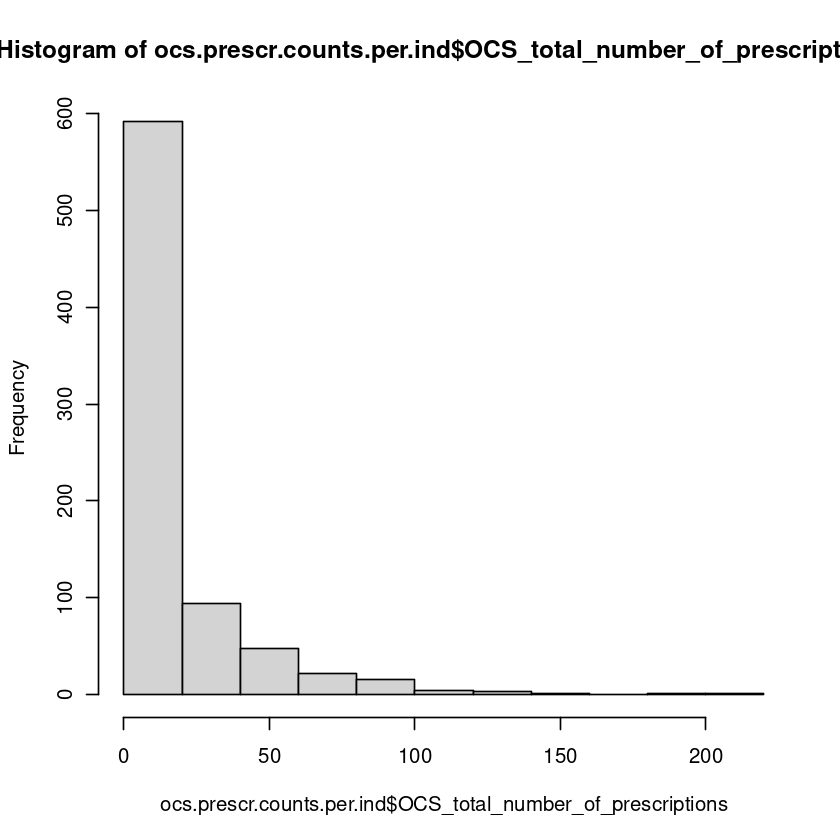

In [251]:
# summary statistic
summary(ocs.prescr.counts.per.ind$OCS_total_number_of_prescriptions)
hist(ocs.prescr.counts.per.ind$OCS_total_number_of_prescriptions)

In [252]:
# Calculate date difference based on plasma collection date
ocs.med.group.w.date <- merge(ocs.med.group.no.dup, data.id[,c('Subject_Id', 'Plasma_collect_date')], 
                              by = 'Subject_Id')
dim(ocs.med.group.w.date)

[1] 13350     5

In [276]:
# convert the date column to the Y-M-D format
ocs.med.group.w.date$Medication_Date <- as.Date(ocs.med.group.w.date$Medication_Date, format = "%m/%d/%Y")
typeof(ocs.med.group.w.date$Medication_Date)
head(ocs.med.group.w.date$Medication_Date)

# plasma collect date
ocs.med.group.w.date$Plasma_collect_date <- as.Date(ocs.med.group.w.date$Plasma_collect_date, format = "%Y -%m -%d")
head(ocs.med.group.w.date$Plasma_collect_date)

[1] "double"

[1] "1993-07-27" "1993-08-24" "1994-03-21" "1995-12-01" "1996-02-07"
[6] "1997-02-28"

[1] "2010-11-03" "2010-11-03" "2010-11-03" "2010-11-03" "2010-11-03"
[6] "2010-11-03"

In [253]:
# substract collect date and diag date
ocs.med.group.w.date["Days_Difference"] <- difftime(ocs.med.group.w.date$Plasma_collect_date, 
                                                    ocs.med.group.w.date$Medication_Date, units = "days")
ocs.med.group.w.date$Days_Difference <- as.numeric(ocs.med.group.w.date$Days_Difference)

# absolute values
ocs.med.group.w.date["Days_Difference_Abs"] <- as.numeric(abs(ocs.med.group.w.date$Days_Difference))
typeof(ocs.med.group.w.date$Days_Difference)
typeof(ocs.med.group.w.date$Days_Difference_Abs)

[1] "double"

[1] "double"

In [254]:
# create a dataset of no of prescriptions within the last 5 years based on sample collection date
ocs.5y <- ocs.med.group.w.date %>% filter(Days_Difference_Abs <= 1826)
dim(ocs.5y)

# check how many individuals have ocs prescriptions within the last 5 years based on sample collection date
length(unique(ocs.5y$Subject_Id)) # only 707 individuals

[1] 9185    7

[1] 707

In [255]:
# Group by Subject_Id and sum of medication date using dplyr
ocs.5y.counts.per.ind <- ocs.5y %>% group_by(Subject_Id) %>% 
  summarise(OCS_total_number_of_prescriptions_within_5y = sum(Prescription),
            .groups = 'drop')
dim(ocs.5y.counts.per.ind)

[1] 707   2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    6.00   12.99   15.00  144.00 

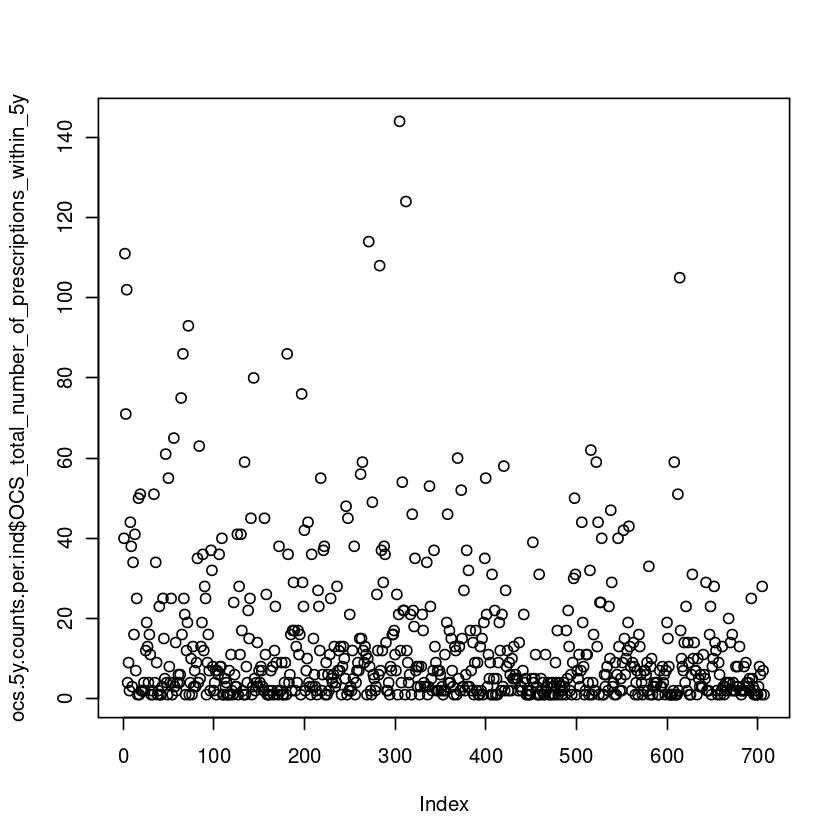

In [256]:
summary(ocs.5y.counts.per.ind$OCS_total_number_of_prescriptions_within_5y)
plot(ocs.5y.counts.per.ind$OCS_total_number_of_prescriptions_within_5y)

## OCS: Number of prescription within 5Y (before plasma collect date)

In [257]:
# create a dataset of no of prescriptions within 5 years before sample collection date
ocs.5y.bef <- ocs.med.group.w.date %>% filter(Days_Difference <= 1826 & Days_Difference >= 0)
dim(ocs.5y.bef)

# check how many individuals have ICS prescriptions within the last 5 years based on sample collection date
length(unique(ocs.5y.bef$Subject_Id)) # only 558 individuals

[1] 4551    7

[1] 558

In [258]:
summary(ocs.5y.bef$Days_Difference)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.1667  295.1667  698.1667  771.6232 1218.1875 1825.2083 

In [259]:
# Group by Subject_Id and sum of medication date using dplyr
ocs.5y.bef.counts.per.ind <- ocs.5y.bef %>% group_by(Subject_Id) %>% 
  summarise(OCS_total_number_of_prescriptions_5y_bef_plasma_collect = sum(Prescription),
            .groups = 'drop')
dim(ocs.5y.bef.counts.per.ind)

[1] 558   2

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   8.156  10.000  82.000 

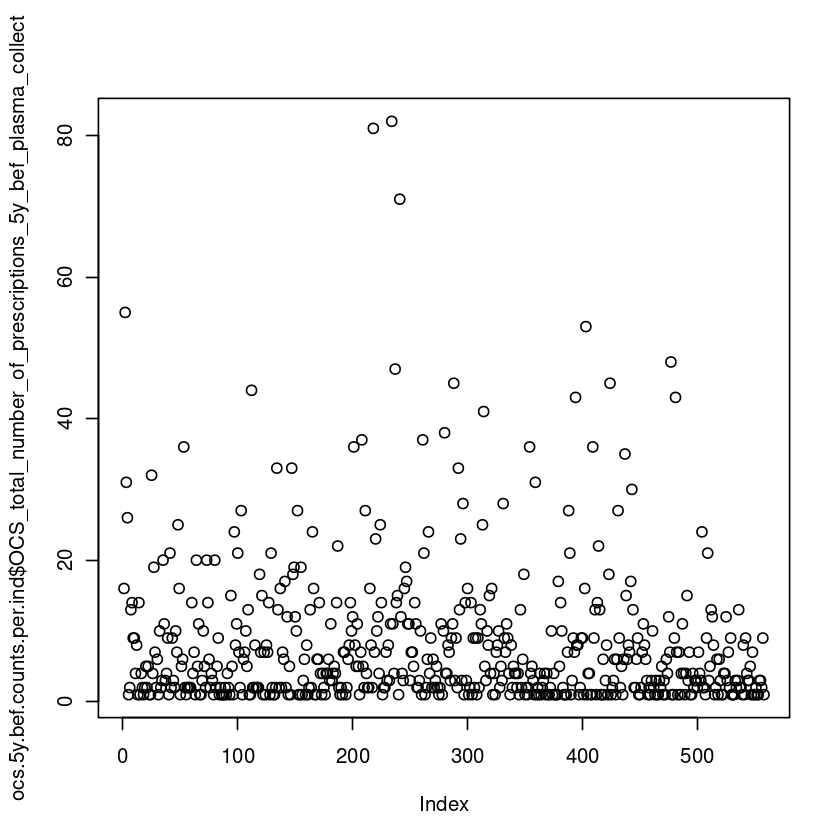

In [260]:
summary(ocs.5y.bef.counts.per.ind$OCS_total_number_of_prescriptions_5y_bef_plasma_collect)
plot(ocs.5y.bef.counts.per.ind$OCS_total_number_of_prescriptions_5y_bef_plasma_collect)

In [261]:
# merge
ocs.presc.counts <- ocs.prescr.counts.per.ind %>% left_join(ocs.5y.bef.counts.per.ind, by = 'Subject_Id') %>%
                                                        left_join(ocs.5y.counts.per.ind, by = 'Subject_Id')
dim(ocs.presc.counts)

[1] 782   4

## OCS: Count number of prescription of each medication group

In [262]:
# create dummy variables for each diag category in ocs.med.group.w.date
ocs.category.no.dup.dummy <- dummy_cols(ocs.med.group.w.date,
                   select_columns = "Medication_group")
dim(ocs.category.no.dup.dummy)

[1] 13350    11

In [263]:
colnames(ocs.category.no.dup.dummy)

[1] "Subject_Id"                                         
 [2] "Medication_Date"                                    
 [3] "Medication_group"                                   
 [4] "Prescription"                                       
 [5] "Plasma_collect_date"                                
 [6] "Days_Difference"                                    
 [7] "Days_Difference_Abs"                                
 [8] "Medication_group_Glucocorticoids_Dexamethasone"     
 [9] "Medication_group_Glucocorticoids_Methylprednisolone"
[10] "Medication_group_Glucocorticoids_Prednisolone"      
[11] "Medication_group_Glucocorticoids_Prednisone"

In [264]:
which(colnames(ocs.category.no.dup.dummy) == 'Medication_group_Glucocorticoids_Dexamethasone')

[1] 8

In [265]:
# check how many counts in each columns
ocs.category.cols <- colnames(ocs.category.no.dup.dummy)[8:ncol(ocs.category.no.dup.dummy)]
for (i in c(1:length(ocs.category.cols))){
  print(ocs.category.cols[i])
  print(table(ocs.category.no.dup.dummy[, ocs.category.cols[i]]))
}

[1] "Medication_group_Glucocorticoids_Dexamethasone"

    0     1 
12711   639 
[1] "Medication_group_Glucocorticoids_Methylprednisolone"

    0     1 
12705   645 
[1] "Medication_group_Glucocorticoids_Prednisolone"

    0     1 
13293    57 
[1] "Medication_group_Glucocorticoids_Prednisone"

    0     1 
 1341 12009 


In [266]:
# group by Subject_Id and sum all columns
ocs.category.no.dup.dummy.group <- ocs.category.no.dup.dummy[,-2:-7] # remove un-neccesary columns
sum.ocs.category <- ocs.category.no.dup.dummy.group %>% group_by(Subject_Id) %>% 
                                                    summarise(across(everything(), sum), .groups = 'drop') %>%
                                                    as.data.frame()
dim(sum.ocs.category)

[1] 782   5

In [267]:
# add column: Yes or No for each medication type
exist.sum.ocs.category <- sum.ocs.category
exist.sum.ocs.category[,-1] <- ifelse(exist.sum.ocs.category[,-1] > 0, 'Yes', 'No')
colnames(exist.sum.ocs.category)[-1] <- paste(colnames(exist.sum.ocs.category[,-1]),'_Existence_Yes_No', sep = '')

In [268]:
# add suffix count after each medication
colnames(sum.ocs.category)[-1]<- paste(colnames(sum.ocs.category[,-1]),"total_prescription",sep="_")

In [269]:
# merge
sum.ocs.category.final <- merge(sum.ocs.category, exist.sum.ocs.category, by = 'Subject_Id')
dim(sum.ocs.category.final)

[1] 782   9

In [270]:
# Remove the "Medication_group_" prefix from all column names
names(sum.ocs.category.final) <- gsub("Medication_group_", "", names(sum.ocs.category.final))
dim(sum.ocs.category.final)

[1] 782   9

In [271]:
# add column: Yes or No for ocs prescp total
sum.ocs.category.final$Any_OCS_Medication_Existence_Yes_No <- 'Yes' # yes for ocs prescp

## OCS: First date

In [272]:
typeof(ocs.med.group.w.date$Medication_Date)

[1] "double"

In [273]:
# find first date in ocs.med.group.w.date
first.ocs.date <- ocs.med.group.w.date %>%                                      # Get min by group
  group_by(Subject_Id, Medication_group) %>%
  summarise_at(vars(Medication_Date),
               list(first_date = min))
dim(first.ocs.date)

[1] 1101    3

In [274]:
# group the data frame by 'Subject_Id' and spread the 'min' column
first.ocs.date.wide <- first.ocs.date %>% group_by(Subject_Id, Medication_group) %>%
                                            pivot_wider(names_from = Medication_group, values_from = first_date)
dim(first.ocs.date.wide)

[1] 782   5

In [275]:
# add suffix first date after each medication group
colnames(first.ocs.date.wide)[-1] <- paste(colnames(first.ocs.date.wide[,-1]),"first_recorded_date",sep="_")

## OCS: Recent date

In [276]:
# find recent date
recent.ocs.date <- ocs.med.group.w.date %>%                                       # Get max by group
  group_by(Subject_Id, Medication_group) %>%
  summarise_at(vars(Medication_Date),
               list(recent_date = max))
dim(recent.ocs.date)

[1] 1101    3

In [277]:
# group the data frame by 'Subject_Id' and spread the 'max' column
recent.ocs.date.wide <- recent.ocs.date %>% group_by(Subject_Id, Medication_group) %>%
                                                    pivot_wider(names_from = Medication_group, values_from = recent_date)
dim(recent.ocs.date.wide)

[1] 782   5

In [278]:
# add suffix recent date after each medication group
colnames(recent.ocs.date.wide)[-1] <- paste(colnames(recent.ocs.date.wide[,-1]),"recent_recorded_date",sep="_")

In [279]:
# merge all above files by the Subject_Id column
ocs.merged <- sum.ocs.category.final %>% left_join(first.ocs.date.wide, by = 'Subject_Id') %>%
                                         left_join(recent.ocs.date.wide, by = 'Subject_Id') %>%
                                         left_join(ocs.presc.counts, by = 'Subject_Id')   
dim(ocs.merged)

[1] 782  21

In [280]:
ocs.merged <- ocs.merged %>% select(Subject_Id,
                                    Any_OCS_Medication_Existence_Yes_No,
                                    OCS_total_number_of_prescriptions,
                                    OCS_total_number_of_prescriptions_within_5y,
                                    OCS_total_number_of_prescriptions_5y_bef_plasma_collect,
                                    Glucocorticoids_Dexamethasone_Existence_Yes_No,
                                    Glucocorticoids_Dexamethasone_first_recorded_date,
                                    Glucocorticoids_Dexamethasone_recent_recorded_date,
                                    Glucocorticoids_Dexamethasone_total_prescription,
                                    Glucocorticoids_Methylprednisolone_Existence_Yes_No,
                                    Glucocorticoids_Methylprednisolone_first_recorded_date,
                                    Glucocorticoids_Methylprednisolone_recent_recorded_date,
                                    Glucocorticoids_Methylprednisolone_total_prescription,
                                    Glucocorticoids_Prednisolone_Existence_Yes_No,
                                    Glucocorticoids_Prednisolone_first_recorded_date,
                                    Glucocorticoids_Prednisolone_recent_recorded_date,
                                    Glucocorticoids_Prednisolone_total_prescription,
                                    Glucocorticoids_Prednisone_Existence_Yes_No,
                                    Glucocorticoids_Prednisone_first_recorded_date,
                                    Glucocorticoids_Prednisone_recent_recorded_date,
                                    Glucocorticoids_Prednisone_total_prescription)
dim(ocs.merged)

[1] 782  21